# Liriscat paper experiments
### 1. Init
#### 1.1. Import libraries (necessary)

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["PYTHONHASHSEED"] = "0"
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"

import liriscat
liriscat.utils.set_seed(0)

import logging
import gc
import json
import torch
liriscat.utils.set_seed(0)
import pandas as pd
from importlib import reload

#### 1.2. Set up the loggers (recommended)

In [2]:
liriscat.utils.setuplogger(verbose = True, log_name="liriscat", debug=False)

### 2. CDM prediction
#### 2.1. Training and testing, sequential version

In [3]:
import warnings

gc.collect()
torch.cuda.empty_cache()

In [4]:
config = liriscat.utils.generate_eval_config(load_params=True, esc = 'error', valid_metric= 'mi_acc', pred_metrics = ["mi_acc"], profile_metrics = ['meta_doa'], save_params=False, n_query=6, num_epochs=30, batch_size=512)
liriscat.utils.set_seed(config["seed"])

config["dataset_name"] = "math2"
logging.info(config["dataset_name"])
config['learning_rate'] = 0.0001
config['inner_user_lr'] = 0.016848380924625605
config['lambda'] = 9.972254466547545e-06

config['patience'] = 5
config['num_inner_users_epochs'] = 3
config['d_in'] = 4
config['num_responses'] = 12

config['meta_trainer'] = 'GAP'
#pred_metrics,df_interp = test(config)

CUDA is available. Using GPU.
[INFO 55:51] math2


In [5]:
logging.info(f'#### {config["dataset_name"]} ####')
logging.info(f'#### config : {config} ####')
config['embs_path']='../embs/'
config['params_path']='../ckpt/'

gc.collect()
torch.cuda.empty_cache()

# Dataset downloading for doa and rm
warnings.filterwarnings("ignore", message="invalid value encountered in divide")
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Concept map format : {question_id : [category_id1, category_id2, ...]}
concept_map = json.load(open(f'../datasets/2-preprocessed_data/{config["dataset_name"]}_concept_map.json', 'r'))
concept_map = {int(k): [int(x) for x in v] for k, v in concept_map.items()}

## Metadata map format : {"num_user_id": ..., "num_item_id": ..., "num_dimension_id": ...}
metadata = json.load(open(f'../datasets/2-preprocessed_data/{config["dataset_name"]}_metadata.json', 'r'))


## Tensor containing the nb of modalities per question
nb_modalities = torch.load(f'../datasets/2-preprocessed_data/{config["dataset_name"]}_nb_modalities.pkl',weights_only=True)


[INFO 55:52] #### math2 ####
[INFO 55:52] #### config : {'seed': 0, 'dataset_name': 'math2', 'load_params': True, 'save_params': False, 'embs_path': '../embs/', 'params_path': '../ckpt/', 'early_stopping': True, 'esc': 'error', 'verbose_early_stopping': False, 'disable_tqdm': False, 'valid_metric': 'mi_acc', 'learning_rate': 0.0001, 'batch_size': 512, 'valid_batch_size': 10000, 'num_epochs': 30, 'eval_freq': 1, 'patience': 5, 'device': device(type='cuda'), 'lambda': 9.972254466547545e-06, 'tensorboard': False, 'flush_freq': True, 'pred_metrics': ['mi_acc'], 'profile_metrics': ['meta_doa'], 'num_responses': 12, 'low_mem': False, 'n_query': 6, 'CDM': 'impact', 'i_fold': 0, 'num_inner_users_epochs': 3, 'num_inner_epochs': 10, 'inner_lr': 0.0001, 'inner_user_lr': 0.016848380924625605, 'meta_trainer': 'GAP', 'num_workers': 0, 'pin_memory': False, 'debug': False, 'd_in': 4} ####


In [6]:
def pareto_index(d) : 
    d_acc = d[0]
    d_meta = d[1]

    r = []

    for i in range(len(d_acc)):
        r.append((0.69-d_acc[i]['mi_acc'])*(0.73-d_meta[i]['meta_doa']))
    return sum(r)

In [8]:
meta_trainers = ['GAP']
for meta_trainer in meta_trainers : 
    config['meta_trainer'] = meta_trainer
    logging.info(f'#### meta_trainer : {config["meta_trainer"]} ####')
    for i_fold in range(1) : 
        config['i_fold'] = i_fold
            
        logging.info(f'#### i_fold : {i_fold} ####')
        ## Dataframe columns : (user_id, question_id, response, category_id)
        train_df = pd.read_csv(
            f'../datasets/2-preprocessed_data/{config["dataset_name"]}_train_{i_fold}.csv',
            encoding='utf-8', dtype={'student_id': int, 'item_id': int, "correct": float,
                                                                    "dimension_id": int})
        valid_df = pd.read_csv(
            f'../datasets/2-preprocessed_data/{config["dataset_name"]}_valid_{i_fold}.csv',
            encoding='utf-8', dtype={'student_id': int, 'item_id': int, "correct": float,
                                                                    "dimension_id": int})
        test_df = pd.read_csv(
            f'../datasets/2-preprocessed_data/{config["dataset_name"]}_test_{i_fold}.csv',
            encoding='utf-8', dtype={'student_id': int, 'item_id': int, "correct": float,
                                                                    "dimension_id": int})

        train_data = liriscat.dataset.CATDataset(train_df, concept_map, metadata, config,nb_modalities)
        valid_data = liriscat.dataset.EvalDataset(valid_df, concept_map, metadata, config,nb_modalities)
        test_data = liriscat.dataset.EvalDataset(test_df, concept_map, metadata, config,nb_modalities)

        for seed in range(1) :
            config['seed'] = seed
            logging.info(f'#### seed : {seed} ####')

            train_data.reset_rng()
            valid_data.reset_rng()
            test_data.reset_rng()

            S = liriscat.selectionStrategy.Random(metadata,**config)
            S.init_models(train_data, valid_data)
            S.train(train_data, valid_data)
            liriscat.utils.set_seed(0)
            S.reset_rng()
            d = (S.evaluate_test(test_data, train_data, valid_data))
            logging.info(d)
            logging.info(pareto_index(d))

    torch.cuda.empty_cache()

[INFO 56:03] #### meta_trainer : GAP ####
[INFO 56:03] #### i_fold : 0 ####
[INFO 56:12] #### seed : 0 ####
[INFO 56:12] Random_cont_model
[INFO 56:13] compiling CDM model
[INFO 56:15] compiling selection model
[INFO 56:15] ------- START Training
[INFO 56:15] train on cuda


NameError: name 'metadata' is not defined

In [33]:
config['meta_trainer'] = 'GAP'
#config['meta_trainer'] = 'Adam'
for seed in range(1) :
    config['seed'] = seed
    logging.info(f'#### seed : {seed} ####')
    
    train_data.reset_rng()
    valid_data.reset_rng()
    test_data.reset_rng()


    S = liriscat.selectionStrategy.Random(metadata,**config)
    S.init_models(train_data, valid_data)
    S.train(train_data, valid_data)
    liriscat.utils.set_seed(0)
    S.reset_rng()
    d = (S.evaluate_test(test_data, train_data, valid_data))
    print(pareto_index(d))
    print(d)
    torch.cuda.empty_cache()

[INFO 32:42] #### seed : 0 ####
[INFO 32:42] Random_cont_model
[INFO 32:42] compiling CDM model
[INFO 32:42] compiling selection model
[INFO 32:42] ------- START Training
[INFO 32:42] train on cuda


/home/arthur/liriscat/liriscat/selectionStrategy/random.py:30: UserWarning: get_params() Notimplemented
  warnings.warn('get_params() Notimplemented')
  0%|          | 0/30 [00:00<?, ?it/s]

[INFO 32:43] ----- User batch : 0
[INFO 32:47] ----- User batch : 1
[INFO 32:52] ----- User batch : 2
[INFO 32:56] ----- User batch : 3
[INFO 33:00] ----- User batch : 4
[INFO 33:02] - meta_params gn: [0.024981128051877022, 0.031466294080019, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 33:02] - cross_cond gn: [0.09998924285173416, 0.12238477915525436, 0.0, 0.0]
[INFO 33:02] - meta_params: [34.032470703125, 160.09890747070312, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 33:02] - cross_cond: [32.93568420410156, 159.80120849609375, 59.474300384521484, 59.921749114990234]
[INFO 33:02] - Current meta lr: 0.07
[INFO 33:02] - Current meta lr: 0.7
[INFO 33:08] Valid L1: 0.09054096043109894, L3: 0.6451811194419861
[INFO 33:08] valid_loss : 0.00019644304120447487


  3%|▎         | 1/30 [00:25<12:18, 25.45s/it]

[INFO 33:09] ----- User batch : 0
[INFO 33:12] ----- User batch : 1
[INFO 33:17] ----- User batch : 2
[INFO 33:21] ----- User batch : 3
[INFO 33:25] ----- User batch : 4
[INFO 33:28] - meta_params gn: [0.022556431591510773, 0.031194591894745827, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 33:28] - cross_cond gn: [0.0936853289604187, 0.1157609298825264, 0.0, 0.0]
[INFO 33:28] - meta_params: [33.894901275634766, 160.08193969726562, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 33:28] - cross_cond: [30.93634796142578, 159.6274871826172, 59.474300384521484, 59.921749114990234]
[INFO 33:28] - Current meta lr: 0.07
[INFO 33:28] - Current meta lr: 0.7
[INFO 33:33] Valid L1: 0.09031346440315247, L3: 0.645844578742981
[INFO 33:33] valid_loss : 0.0001964497205335647


  7%|▋         | 2/30 [00:50<11:48, 25.29s/it]

[INFO 33:34] ----- User batch : 0
[INFO 33:38] ----- User batch : 1
[INFO 33:42] ----- User batch : 2
[INFO 33:47] ----- User batch : 3
[INFO 33:50] ----- User batch : 4
[INFO 33:53] - meta_params gn: [0.024208279326558113, 0.03406980261206627, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 33:53] - cross_cond gn: [0.09698092937469482, 0.11963357031345367, 0.0, 0.0]
[INFO 33:53] - meta_params: [33.736026763916016, 160.0650177001953, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 33:53] - cross_cond: [29.060592651367188, 159.45693969726562, 59.474300384521484, 59.921749114990234]
[INFO 33:53] - Current meta lr: 0.07
[INFO 33:53] - Current meta lr: 0.7
[INFO 33:59] Valid L1: 0.09147901087999344, L3: 0.6466789841651917
[INFO 33:59] valid_loss : 0.00019752944353967905


 10%|█         | 3/30 [01:16<11:26, 25.43s/it]

[INFO 33:59] ----- User batch : 0
[INFO 34:04] ----- User batch : 1
[INFO 34:07] ----- User batch : 2
[INFO 34:12] ----- User batch : 3
[INFO 34:16] ----- User batch : 4
[INFO 34:18] - meta_params gn: [0.018156101927161217, 0.01705448515713215, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 34:18] - cross_cond gn: [0.11112043261528015, 0.1212865486741066, 0.0, 0.0]
[INFO 34:18] - meta_params: [33.577369689941406, 160.04806518554688, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 34:18] - cross_cond: [27.274898529052734, 159.2891082763672, 59.474300384521484, 59.921749114990234]
[INFO 34:18] - Current meta lr: 0.07
[INFO 34:18] - Current meta lr: 0.7
[INFO 34:24] Valid L1: 0.08967521041631699, L3: 0.646033763885498
[INFO 34:24] valid_loss : 0.00019530545978341252


 13%|█▎        | 4/30 [01:41<10:58, 25.33s/it]

[INFO 34:24] ----- User batch : 0
[INFO 34:29] ----- User batch : 1
[INFO 34:33] ----- User batch : 2
[INFO 34:37] ----- User batch : 3
[INFO 34:41] ----- User batch : 4
[INFO 34:43] - meta_params gn: [0.02108657732605934, 0.028557613492012024, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 34:43] - cross_cond gn: [0.06329505890607834, 0.0784943699836731, 0.0, 0.0]
[INFO 34:43] - meta_params: [33.4390754699707, 160.03196716308594, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 34:43] - cross_cond: [25.651142120361328, 159.1239776611328, 59.474300384521484, 59.921749114990234]
[INFO 34:43] - Current meta lr: 0.07
[INFO 34:43] - Current meta lr: 0.7
[INFO 34:47] Valid L1: 0.08993992209434509, L3: 0.6464245319366455
[INFO 34:47] valid_loss : 0.0001958306966116652


 17%|█▋        | 5/30 [02:04<10:13, 24.53s/it]

[INFO 34:48] ----- User batch : 0
[INFO 34:51] ----- User batch : 1
[INFO 34:54] ----- User batch : 2
[INFO 34:57] ----- User batch : 3
[INFO 35:00] ----- User batch : 4
[INFO 35:02] - meta_params gn: [0.01921258121728897, 0.0234052836894989, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 35:02] - cross_cond gn: [0.06617866456508636, 0.09026172757148743, 0.0, 0.0]
[INFO 35:02] - meta_params: [33.29723358154297, 160.01573181152344, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 35:02] - cross_cond: [24.16777992248535, 158.96609497070312, 59.474300384521484, 59.921749114990234]
[INFO 35:02] - Current meta lr: 0.07
[INFO 35:02] - Current meta lr: 0.7
[INFO 35:06] Valid L1: 0.09036360681056976, L3: 0.6470611691474915
[INFO 35:06] valid_loss : 0.0001947677374118939


 20%|██        | 6/30 [02:23<09:01, 22.58s/it]

[INFO 35:06] ----- User batch : 0
[INFO 35:10] ----- User batch : 1
[INFO 35:13] ----- User batch : 2
[INFO 35:16] ----- User batch : 3
[INFO 35:19] ----- User batch : 4
[INFO 35:21] - meta_params gn: [0.01738690212368965, 0.01848558336496353, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 35:21] - cross_cond gn: [0.06630193442106247, 0.09350571036338806, 0.0, 0.0]
[INFO 35:21] - meta_params: [33.15974426269531, 159.9996337890625, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 35:21] - cross_cond: [22.787765502929688, 158.8121337890625, 59.474300384521484, 59.921749114990234]
[INFO 35:21] - Current meta lr: 0.07
[INFO 35:21] - Current meta lr: 0.7
[INFO 35:25] Valid L1: 0.08975573629140854, L3: 0.6470516324043274
[INFO 35:25] valid_loss : 0.0001937549968715757


 23%|██▎       | 7/30 [02:42<08:13, 21.47s/it]

[INFO 35:26] ----- User batch : 0
[INFO 35:28] ----- User batch : 1
[INFO 35:32] ----- User batch : 2
[INFO 35:35] ----- User batch : 3
[INFO 35:38] ----- User batch : 4
[INFO 35:40] - meta_params gn: [0.01328397449105978, 0.013765755109488964, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 35:40] - cross_cond gn: [0.04346368834376335, 0.0631791353225708, 0.0, 0.0]
[INFO 35:40] - meta_params: [33.02536392211914, 159.98388671875, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 35:40] - cross_cond: [21.560022354125977, 158.66127014160156, 59.474300384521484, 59.921749114990234]
[INFO 35:40] - Current meta lr: 0.07
[INFO 35:40] - Current meta lr: 0.7
[INFO 35:44] Valid L1: 0.0891660824418068, L3: 0.6452710628509521
[INFO 35:44] valid_loss : 0.00019307952607050538


 27%|██▋       | 8/30 [03:01<07:33, 20.63s/it]

[INFO 35:44] ----- User batch : 0
[INFO 35:48] ----- User batch : 1
[INFO 35:51] ----- User batch : 2
[INFO 35:54] ----- User batch : 3
[INFO 35:57] ----- User batch : 4
[INFO 35:59] - meta_params gn: [0.016868626698851585, 0.025810835883021355, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 35:59] - cross_cond gn: [0.0646180510520935, 0.08588781952857971, 0.0, 0.0]
[INFO 35:59] - meta_params: [32.89847946166992, 159.96873474121094, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 35:59] - cross_cond: [20.48927116394043, 158.51718139648438, 59.474300384521484, 59.921749114990234]
[INFO 35:59] - Current meta lr: 0.07
[INFO 35:59] - Current meta lr: 0.7
[INFO 36:03] Valid L1: 0.08937576413154602, L3: 0.6473990678787231
[INFO 36:03] valid_loss : 0.00019329927454236895


 30%|███       | 9/30 [03:20<07:03, 20.19s/it]

[INFO 36:04] ----- User batch : 0
[INFO 36:06] ----- User batch : 1
[INFO 36:10] ----- User batch : 2
[INFO 36:13] ----- User batch : 3
[INFO 36:16] ----- User batch : 4
[INFO 36:18] - meta_params gn: [0.019869454205036163, 0.01789207011461258, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 36:18] - cross_cond gn: [0.0433228500187397, 0.05994996055960655, 0.0, 0.0]
[INFO 36:18] - meta_params: [32.76487350463867, 159.95333862304688, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 36:18] - cross_cond: [19.653268814086914, 158.375732421875, 59.474300384521484, 59.921749114990234]
[INFO 36:18] - Current meta lr: 0.07
[INFO 36:18] - Current meta lr: 0.7
[INFO 36:22] Valid L1: 0.08956029266119003, L3: 0.6473764777183533
[INFO 36:22] valid_loss : 0.00019273345242254436


 33%|███▎      | 10/30 [03:39<06:35, 19.76s/it]

[INFO 36:22] ----- User batch : 0
[INFO 36:26] ----- User batch : 1
[INFO 36:29] ----- User batch : 2
[INFO 36:32] ----- User batch : 3
[INFO 36:35] ----- User batch : 4
[INFO 36:37] - meta_params gn: [0.01788455620408058, 0.02301321178674698, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 36:37] - cross_cond gn: [0.04446219280362129, 0.07801812887191772, 0.0, 0.0]
[INFO 36:37] - meta_params: [32.6379280090332, 159.93817138671875, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 36:37] - cross_cond: [19.119522094726562, 158.2401580810547, 59.474300384521484, 59.921749114990234]
[INFO 36:37] - Current meta lr: 0.07
[INFO 36:37] - Current meta lr: 0.7
[INFO 36:41] Valid L1: 0.08911903947591782, L3: 0.6477431654930115
[INFO 36:41] valid_loss : 0.00019130136934109032


 37%|███▋      | 11/30 [03:58<06:11, 19.55s/it]

[INFO 36:41] ----- User batch : 0
[INFO 36:44] ----- User batch : 1
[INFO 36:48] ----- User batch : 2
[INFO 36:51] ----- User batch : 3
[INFO 36:54] ----- User batch : 4
[INFO 36:55] - meta_params gn: [0.016705410555005074, 0.022507956251502037, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 36:55] - cross_cond gn: [0.03384176641702652, 0.05973311886191368, 0.0, 0.0]
[INFO 36:55] - meta_params: [32.51054000854492, 159.9228973388672, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 36:55] - cross_cond: [18.768539428710938, 158.1072540283203, 59.474300384521484, 59.921749114990234]
[INFO 36:55] - Current meta lr: 0.07
[INFO 36:55] - Current meta lr: 0.7
[INFO 37:00] Valid L1: 0.08903966099023819, L3: 0.6472663283348083
[INFO 37:00] valid_loss : 0.0001911549479700625


 40%|████      | 12/30 [04:17<05:47, 19.33s/it]

[INFO 37:00] ----- User batch : 0
[INFO 37:03] ----- User batch : 1
[INFO 37:07] ----- User batch : 2
[INFO 37:10] ----- User batch : 3
[INFO 37:13] ----- User batch : 4
[INFO 37:15] - meta_params gn: [0.025431953370571136, 0.03453194350004196, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 37:15] - cross_cond gn: [0.04097110405564308, 0.07784891128540039, 0.0, 0.0]
[INFO 37:15] - meta_params: [32.3803825378418, 159.90756225585938, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 37:15] - cross_cond: [18.688810348510742, 157.97923278808594, 59.474300384521484, 59.921749114990234]
[INFO 37:15] - Current meta lr: 0.07
[INFO 37:15] - Current meta lr: 0.7
[INFO 37:19] Valid L1: 0.08805521577596664, L3: 0.6485750079154968
[INFO 37:19] valid_loss : 0.00018898477719631046


 43%|████▎     | 13/30 [04:36<05:25, 19.16s/it]

[INFO 37:19] ----- User batch : 0
[INFO 37:22] ----- User batch : 1
[INFO 37:25] ----- User batch : 2
[INFO 37:29] ----- User batch : 3
[INFO 37:32] ----- User batch : 4
[INFO 37:33] - meta_params gn: [0.020305603742599487, 0.026695596054196358, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 37:33] - cross_cond gn: [0.03121049515902996, 0.07489506900310516, 0.0, 0.0]
[INFO 37:33] - meta_params: [32.24277114868164, 159.8917694091797, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 37:33] - cross_cond: [18.834672927856445, 157.85325622558594, 59.474300384521484, 59.921749114990234]
[INFO 37:33] - Current meta lr: 0.07
[INFO 37:33] - Current meta lr: 0.7
[INFO 37:38] Valid L1: 0.08787605166435242, L3: 0.6481509208679199
[INFO 37:38] valid_loss : 0.00018735611229203641


 47%|████▋     | 14/30 [04:55<05:06, 19.16s/it]

[INFO 37:38] ----- User batch : 0
[INFO 37:41] ----- User batch : 1
[INFO 37:44] ----- User batch : 2
[INFO 37:48] ----- User batch : 3
[INFO 37:51] ----- User batch : 4
[INFO 37:53] - meta_params gn: [0.021447740495204926, 0.02849910967051983, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 37:53] - cross_cond gn: [0.01920401118695736, 0.05959850177168846, 0.0, 0.0]
[INFO 37:53] - meta_params: [32.10251998901367, 159.8758544921875, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 37:53] - cross_cond: [19.244535446166992, 157.72967529296875, 59.474300384521484, 59.921749114990234]
[INFO 37:53] - Current meta lr: 0.07
[INFO 37:53] - Current meta lr: 0.7
[INFO 37:58] Valid L1: 0.08987577259540558, L3: 0.6491182446479797
[INFO 37:58] valid_loss : 0.00018941394228022546


 50%|█████     | 15/30 [05:14<04:50, 19.35s/it]

[INFO 37:58] ----- User batch : 0
[INFO 38:02] ----- User batch : 1
[INFO 38:07] ----- User batch : 2
[INFO 38:11] ----- User batch : 3
[INFO 38:15] ----- User batch : 4
[INFO 38:17] - meta_params gn: [0.018545616418123245, 0.022671833634376526, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 38:17] - cross_cond gn: [0.009015108458697796, 0.04061013087630272, 0.0, 0.0]
[INFO 38:17] - meta_params: [31.957990646362305, 159.85977172851562, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 38:17] - cross_cond: [19.83342170715332, 157.61029052734375, 59.474300384521484, 59.921749114990234]
[INFO 38:17] - Current meta lr: 0.07
[INFO 38:17] - Current meta lr: 0.7
[INFO 38:23] Valid L1: 0.08842188119888306, L3: 0.6478917598724365
[INFO 38:23] valid_loss : 0.0001870501000666991


 53%|█████▎    | 16/30 [05:40<04:56, 21.21s/it]

[INFO 38:24] ----- User batch : 0
[INFO 38:27] ----- User batch : 1
[INFO 38:32] ----- User batch : 2
[INFO 38:36] ----- User batch : 3
[INFO 38:40] ----- User batch : 4
[INFO 38:42] - meta_params gn: [0.018929747864603996, 0.02575335092842579, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 38:42] - cross_cond gn: [0.00860979687422514, 0.059081822633743286, 0.0, 0.0]
[INFO 38:42] - meta_params: [31.815370559692383, 159.84381103515625, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 38:42] - cross_cond: [20.49692726135254, 157.49732971191406, 59.474300384521484, 59.921749114990234]
[INFO 38:42] - Current meta lr: 0.07
[INFO 38:42] - Current meta lr: 0.7
[INFO 38:49] Valid L1: 0.08842481672763824, L3: 0.6482129693031311
[INFO 38:49] valid_loss : 0.00018643886141944677


 57%|█████▋    | 17/30 [06:05<04:51, 22.42s/it]

[INFO 38:49] ----- User batch : 0
[INFO 38:53] ----- User batch : 1
[INFO 38:57] ----- User batch : 2
[INFO 39:01] ----- User batch : 3
[INFO 39:05] ----- User batch : 4
[INFO 39:08] - meta_params gn: [0.01629743166267872, 0.020899124443531036, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 39:08] - cross_cond gn: [0.006270920857787132, 0.048352573066949844, 0.0, 0.0]
[INFO 39:08] - meta_params: [31.670259475708008, 159.8278045654297, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 39:08] - cross_cond: [21.20286750793457, 157.38746643066406, 59.474300384521484, 59.921749114990234]
[INFO 39:08] - Current meta lr: 0.07
[INFO 39:08] - Current meta lr: 0.7
[INFO 39:14] Valid L1: 0.08822006732225418, L3: 0.647773802280426
[INFO 39:14] valid_loss : 0.0001856705785030499


 60%|██████    | 18/30 [06:30<04:39, 23.26s/it]

[INFO 39:14] ----- User batch : 0
[INFO 39:18] ----- User batch : 1
[INFO 39:22] ----- User batch : 2
[INFO 39:27] ----- User batch : 3
[INFO 39:31] ----- User batch : 4
[INFO 39:33] - meta_params gn: [0.04639426991343498, 0.05931571498513222, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 39:33] - cross_cond gn: [0.004302539397031069, 0.043980590999126434, 0.0, 0.0]
[INFO 39:33] - meta_params: [31.525423049926758, 159.81198120117188, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 39:33] - cross_cond: [21.99388313293457, 157.28192138671875, 59.474300384521484, 59.921749114990234]
[INFO 39:33] - Current meta lr: 0.07
[INFO 39:33] - Current meta lr: 0.7
[INFO 39:39] Valid L1: 0.08851762115955353, L3: 0.6485737562179565
[INFO 39:39] valid_loss : 0.00017821560322772712


 63%|██████▎   | 19/30 [06:56<04:23, 23.95s/it]

[INFO 39:40] ----- User batch : 0
[INFO 39:43] ----- User batch : 1
[INFO 39:48] ----- User batch : 2
[INFO 39:52] ----- User batch : 3
[INFO 39:55] ----- User batch : 4
[INFO 39:57] - meta_params gn: [0.014582197181880474, 0.018914591521024704, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 39:57] - cross_cond gn: [0.004091902170330286, 0.07144008576869965, 0.0, 0.0]
[INFO 39:57] - meta_params: [31.372278213500977, 159.79539489746094, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 39:57] - cross_cond: [22.817581176757812, 157.1808319091797, 59.474300384521484, 59.921749114990234]
[INFO 39:57] - Current meta lr: 0.07
[INFO 39:57] - Current meta lr: 0.7
[INFO 40:01] Valid L1: 0.0877092257142067, L3: 0.6473380923271179
[INFO 40:01] valid_loss : 0.00017691749962978065


 67%|██████▋   | 20/30 [07:18<03:52, 23.30s/it]

[INFO 40:01] ----- User batch : 0
[INFO 40:04] ----- User batch : 1
[INFO 40:08] ----- User batch : 2
[INFO 40:11] ----- User batch : 3
[INFO 40:14] ----- User batch : 4
[INFO 40:16] - meta_params gn: [0.012833727523684502, 0.016371121630072594, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 40:16] - cross_cond gn: [0.0039402940310537815, 0.06243842840194702, 0.0, 0.0]
[INFO 40:16] - meta_params: [31.222034454345703, 159.77923583984375, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 40:16] - cross_cond: [23.634429931640625, 157.08026123046875, 59.474300384521484, 59.921749114990234]
[INFO 40:16] - Current meta lr: 0.07
[INFO 40:16] - Current meta lr: 0.7
[INFO 40:20] Valid L1: 0.08827964216470718, L3: 0.648128092288971
[INFO 40:20] valid_loss : 0.00017793040024116635


 70%|███████   | 21/30 [07:37<03:18, 22.04s/it]

[INFO 40:20] ----- User batch : 0
[INFO 40:24] ----- User batch : 1
[INFO 40:26] ----- User batch : 2
[INFO 40:30] ----- User batch : 3
[INFO 40:33] ----- User batch : 4
[INFO 40:35] - meta_params gn: [0.015410710126161575, 0.013442175462841988, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 40:35] - cross_cond gn: [0.0023627926129847765, 0.039581298828125, 0.0, 0.0]
[INFO 40:35] - meta_params: [31.076187133789062, 159.76361083984375, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 40:35] - cross_cond: [24.46247100830078, 156.9814910888672, 59.474300384521484, 59.921749114990234]
[INFO 40:35] - Current meta lr: 0.07
[INFO 40:35] - Current meta lr: 0.7
[INFO 40:39] Valid L1: 0.08815088123083115, L3: 0.6481593251228333
[INFO 40:39] valid_loss : 0.00017784266674425453


 73%|███████▎  | 22/30 [07:56<02:48, 21.06s/it]

[INFO 40:39] ----- User batch : 0
[INFO 40:42] ----- User batch : 1
[INFO 40:46] ----- User batch : 2
[INFO 40:49] ----- User batch : 3
[INFO 40:53] ----- User batch : 4
[INFO 40:56] - meta_params gn: [0.016869762912392616, 0.01459092739969492, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 40:56] - cross_cond gn: [0.0017672455869615078, 0.042906299233436584, 0.0, 0.0]
[INFO 40:56] - meta_params: [30.939807891845703, 159.7485809326172, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 40:56] - cross_cond: [25.261737823486328, 156.88743591308594, 59.474300384521484, 59.921749114990234]
[INFO 40:56] - Current meta lr: 0.07
[INFO 40:56] - Current meta lr: 0.7
[INFO 41:02] Valid L1: 0.08815734833478928, L3: 0.6486345529556274
[INFO 41:02] valid_loss : 0.0001777160941855982


 77%|███████▋  | 23/30 [08:19<02:31, 21.60s/it]

[INFO 41:02] ----- User batch : 0
[INFO 41:06] ----- User batch : 1
[INFO 41:10] ----- User batch : 2
[INFO 41:15] ----- User batch : 3
[INFO 41:19] ----- User batch : 4
[INFO 41:21] - meta_params gn: [0.013613552786409855, 0.017473801970481873, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 41:21] - cross_cond gn: [0.0006366910529322922, 0.02641984075307846, 0.0, 0.0]
[INFO 41:21] - meta_params: [30.80999755859375, 159.73403930664062, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 41:21] - cross_cond: [26.031570434570312, 156.79714965820312, 59.474300384521484, 59.921749114990234]
[INFO 41:21] - Current meta lr: 0.035
[INFO 41:21] - Current meta lr: 0.35
[INFO 41:27] Valid L1: 0.08751369267702103, L3: 0.64798903465271
[INFO 41:27] valid_loss : 0.0001767105859471485


 80%|████████  | 24/30 [08:44<02:16, 22.68s/it]

[INFO 41:27] ----- User batch : 0
[INFO 41:31] ----- User batch : 1
[INFO 41:36] ----- User batch : 2
[INFO 41:40] ----- User batch : 3
[INFO 41:44] ----- User batch : 4
[INFO 41:47] - meta_params gn: [0.015919199213385582, 0.013777589425444603, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 41:47] - cross_cond gn: [0.0008052364573813975, 0.025861287489533424, 0.0, 0.0]
[INFO 41:47] - meta_params: [30.745973587036133, 159.7268829345703, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 41:47] - cross_cond: [26.388469696044922, 156.75465393066406, 59.474300384521484, 59.921749114990234]
[INFO 41:47] - Current meta lr: 0.035
[INFO 41:47] - Current meta lr: 0.35
[INFO 41:52] Valid L1: 0.08806079626083374, L3: 0.649316132068634
[INFO 41:52] valid_loss : 0.00017738097812980413


 83%|████████▎ | 25/30 [09:09<01:57, 23.49s/it]

[INFO 41:53] ----- User batch : 0
[INFO 41:57] ----- User batch : 1
[INFO 42:01] ----- User batch : 2
[INFO 42:06] ----- User batch : 3
[INFO 42:10] ----- User batch : 4
[INFO 42:12] - meta_params gn: [0.019615329802036285, 0.01676829159259796, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 42:12] - cross_cond gn: [0.0018211714923381805, 0.05038171634078026, 0.0, 0.0]
[INFO 42:12] - meta_params: [30.68592071533203, 159.71995544433594, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 42:12] - cross_cond: [26.706972122192383, 156.71432495117188, 59.474300384521484, 59.921749114990234]
[INFO 42:12] - Current meta lr: 0.035
[INFO 42:12] - Current meta lr: 0.35
[INFO 42:18] Valid L1: 0.08796990662813187, L3: 0.6483400464057922
[INFO 42:18] valid_loss : 0.00017708259110804647


 87%|████████▋ | 26/30 [09:35<01:36, 24.19s/it]

[INFO 42:18] ----- User batch : 0
[INFO 42:23] ----- User batch : 1
[INFO 42:26] ----- User batch : 2
[INFO 42:29] ----- User batch : 3
[INFO 42:32] ----- User batch : 4
[INFO 42:34] - meta_params gn: [0.011075692251324654, 0.011331891641020775, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 42:34] - cross_cond gn: [0.0014788152184337378, 0.02311136946082115, 0.0, 0.0]
[INFO 42:34] - meta_params: [30.627885818481445, 159.713134765625, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 42:34] - cross_cond: [27.017778396606445, 156.67425537109375, 59.474300384521484, 59.921749114990234]
[INFO 42:34] - Current meta lr: 0.035
[INFO 42:34] - Current meta lr: 0.35
[INFO 42:39] Valid L1: 0.08734892308712006, L3: 0.6481653451919556
[INFO 42:39] valid_loss : 0.0001763294276315719


 90%|█████████ | 27/30 [09:56<01:09, 23.13s/it]

[INFO 42:39] ----- User batch : 0
[INFO 42:42] ----- User batch : 1
[INFO 42:46] ----- User batch : 2
[INFO 42:49] ----- User batch : 3
[INFO 42:52] ----- User batch : 4
[INFO 42:54] - meta_params gn: [0.018831852823495865, 0.01413731835782528, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 42:54] - cross_cond gn: [0.001238674041815102, 0.03597545996308327, 0.0, 0.0]
[INFO 42:54] - meta_params: [30.572052001953125, 159.70655822753906, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 42:54] - cross_cond: [27.307504653930664, 156.63632202148438, 59.474300384521484, 59.921749114990234]
[INFO 42:54] - Current meta lr: 0.035
[INFO 42:54] - Current meta lr: 0.35
[INFO 42:58] Valid L1: 0.08694776892662048, L3: 0.6478487253189087
[INFO 42:58] valid_loss : 0.00017580580606590956


 93%|█████████▎| 28/30 [10:15<00:44, 22.07s/it]

[INFO 42:59] ----- User batch : 0
[INFO 43:02] ----- User batch : 1
[INFO 43:05] ----- User batch : 2
[INFO 43:09] ----- User batch : 3
[INFO 43:12] ----- User batch : 4
[INFO 43:14] - meta_params gn: [0.018816862255334854, 0.024149982258677483, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 43:14] - cross_cond gn: [0.0006150036351755261, 0.03963632136583328, 0.0, 0.0]
[INFO 43:14] - meta_params: [30.518260955810547, 159.7001190185547, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 43:14] - cross_cond: [27.572664260864258, 156.59939575195312, 59.474300384521484, 59.921749114990234]
[INFO 43:14] - Current meta lr: 0.035
[INFO 43:14] - Current meta lr: 0.35
[INFO 43:18] Valid L1: 0.08817808330059052, L3: 0.6487497687339783
[INFO 43:18] valid_loss : 0.0001771922834450379


 97%|█████████▋| 29/30 [10:35<00:21, 21.36s/it]

[INFO 43:18] ----- User batch : 0
[INFO 43:22] ----- User batch : 1
[INFO 43:24] ----- User batch : 2
[INFO 43:28] ----- User batch : 3
[INFO 43:31] ----- User batch : 4
[INFO 43:33] - meta_params gn: [0.019742226228117943, 0.023939114063978195, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 43:33] - cross_cond gn: [0.001819493598304689, 0.05303123593330383, 0.0, 0.0]
[INFO 43:33] - meta_params: [30.462825775146484, 159.6935272216797, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 43:33] - cross_cond: [27.814437866210938, 156.56307983398438, 59.474300384521484, 59.921749114990234]
[INFO 43:33] - Current meta lr: 0.035
[INFO 43:33] - Current meta lr: 0.35
[INFO 43:38] Valid L1: 0.08733321726322174, L3: 0.6473807096481323
[INFO 43:38] valid_loss : 0.0001759857259457931


100%|██████████| 30/30 [10:54<00:00, 20.79s/it]

[INFO 43:38] ----- User batch : 0
[INFO 43:41] ----- User batch : 1
[INFO 43:44] ----- User batch : 2
[INFO 43:47] ----- User batch : 3
[INFO 43:51] ----- User batch : 4
[INFO 43:52] - meta_params gn: [0.014057560823857784, 0.009617415256798267, 0.0, 0.0, 0.0, 0.0, 0.0]
[INFO 43:52] - cross_cond gn: [0.0009333307389169931, 0.018174758180975914, 0.0, 0.0]
[INFO 43:52] - meta_params: [30.40571403503418, 159.68679809570312, 23.690677642822266, 2.105262517929077, 2.2069685459136963, 1.590973138809204, 2.0424320697784424]
[INFO 43:52] - cross_cond: [28.010311126708984, 156.52642822265625, 59.474300384521484, 59.921749114990234]
[INFO 43:52] - Current meta lr: 0.035
[INFO 43:52] - Current meta lr: 0.35
[INFO 43:57] Valid L1: 0.0882640928030014, L3: 0.6483522653579712
[INFO 43:57] valid_loss : 0.00017715203284751624


31it [11:14, 21.75s/it]                        

[INFO 43:57] -- END Training --
[INFO 43:57] train on cuda



100%|██████████| 6/6 [00:04<00:00,  1.30it/s]


0.002276808043682531
({0: {'mi_acc': 0.6996511816978455}, 1: {'mi_acc': 0.707423985004425}, 2: {'mi_acc': 0.7085201740264893}, 3: {'mi_acc': 0.7094169855117798}, 4: {'mi_acc': 0.7175884246826172}, 5: {'mi_acc': 0.7176880836486816}}, {0: {'meta_doa': 0.7310681233206116}, 1: {'meta_doa': 0.7366508752331963}, 2: {'meta_doa': 0.7424744741524893}, 3: {'meta_doa': 0.7485661559709291}, 4: {'meta_doa': 0.7551271281186389}, 5: {'meta_doa': 0.7612722453751236}})


In [34]:
S.best_epoch

27

In [34]:
S.cross_cond[:2,0]

tensor([36.8987, 36.9663], grad_fn=<SelectBackward0>)

In [32]:
inverse_softplus(torch.tensor(S.config['inner_user_lr']*500))

tensor(8.4240)

In [30]:
def inverse_softplus(x):
    """
    Compute the inverse of the softplus function.
    
    For numerical stability, uses different approaches based on input magnitude:
    - For large x: log(x) (since softplus(y) ≈ y for large y)
    - For small x: log(exp(x) - 1) (direct inverse)
    
    Args:
        x: Input tensor
        
    Returns:
        Inverse softplus of x
    """
    return torch.where(x > 20, torch.log(x), torch.log(torch.expm1(x)))

In [10]:
torch.nn.Softplus()(S.meta_mu)

tensor([3.7773e-10], device='cuda:0', grad_fn=<SoftplusBackward0>)

In [17]:
S.config['lambda']*torch.arange(S.config['n_query'],0,-1, device=S.device, dtype=torch.float32)

tensor([5.9834e-05, 4.9861e-05, 3.9889e-05, 2.9917e-05, 1.9945e-05, 9.9723e-06],
       device='cuda:0')

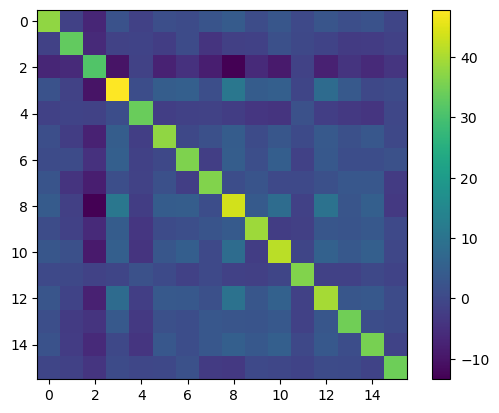

In [48]:
import matplotlib.pyplot as plt

plt.imshow(S.CDM.model.prior_cov_inv.cpu().detach().numpy())
plt.colorbar()

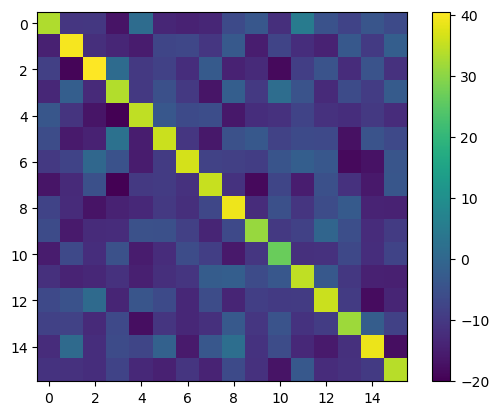

In [49]:
import matplotlib.pyplot as plt

plt.imshow(S.meta_lambda.cpu().detach().numpy())
plt.colorbar()

In [34]:
S.CDM.model.prior_cov_inv.norm()

tensor(161.6913, device='cuda:0')

In [ ]:
import re
import numpy as np
import ast
from collections import defaultdict

# Copiez ici tout votre log dans la variable "log_data"
log_data = """[INFO 45:37] Fold 0; pareto_index: 5.116818038767275; results: ({0: {'mi_acc': 0.7000665068626404, 'rmse': 0.5476618409156799, 'mae': 0.29993346333503723, 'mi_prec': 0.6649700403213501, 'mi_rec': 0.6617997884750366, 'mi_f_b': 0.6633811593055725, 'mi_auc': 0.6963723501540809, 'ma_prec': 0.6965568661689758, 'ma_rec': 0.696372389793396, 'ma_f_b': 0.6964614391326904}, 1: {'mi_acc': 0.7000665068626404, 'rmse': 0.5476618409156799, 'mae': 0.29993346333503723, 'mi_prec': 0.6649700403213501, 'mi_rec': 0.6617997884750366, 'mi_f_b': 0.6633811593055725, 'mi_auc': 0.6963723501540809, 'ma_prec': 0.6965568661689758, 'ma_rec': 0.696372389793396, 'ma_f_b': 0.6964614391326904}, 2: {'mi_acc': 0.7005987763404846, 'rmse': 0.5471756458282471, 'mae': 0.299401193857193, 'mi_prec': 0.6649700403213501, 'mi_rec': 0.6625894904136658, 'mi_f_b': 0.6637776494026184, 'mi_auc': 0.6968964789253207, 'ma_prec': 0.6970359086990356, 'ma_rec': 0.6968964338302612, 'ma_f_b': 0.6969643831253052}, 3: {'mi_acc': 0.7005987763404846, 'rmse': 0.5471756458282471, 'mae': 0.299401193857193, 'mi_prec': 0.660179615020752, 'mi_rec': 0.6641566157341003, 'mi_f_b': 0.6621620655059814, 'mi_auc': 0.6967982179014031, 'ma_prec': 0.6965568661689758, 'ma_rec': 0.6967982053756714, 'ma_f_b': 0.6966724395751953}, 4: {'mi_acc': 0.70379239320755, 'rmse': 0.5442495346069336, 'mae': 0.29620757699012756, 'mi_prec': 0.6553892493247986, 'mi_rec': 0.670649528503418, 'mi_f_b': 0.6629315614700317, 'mi_auc': 0.6999448442926924, 'ma_prec': 0.6989520788192749, 'ma_rec': 0.6999448537826538, 'ma_f_b': 0.6993746161460876}, 5: {'mi_acc': 0.7043246626853943, 'rmse': 0.543760359287262, 'mae': 0.2956753075122833, 'mi_prec': 0.6505988240242004, 'mi_rec': 0.6731722354888916, 'mi_f_b': 0.6616930961608887, 'mi_auc': 0.7004769541875976, 'ma_prec': 0.6989520788192749, 'ma_rec': 0.7004769444465637, 'ma_f_b': 0.6995537281036377}, 6: {'mi_acc': 0.7032601237297058, 'rmse': 0.5447383522987366, 'mae': 0.2967398464679718, 'mi_prec': 0.6482036113739014, 'mi_rec': 0.6723602414131165, 'mi_f_b': 0.6600610017776489, 'mi_auc': 0.6993931626403662, 'ma_prec': 0.6977545022964478, 'ma_rec': 0.6993931531906128, 'ma_f_b': 0.6983894109725952}, 7: {'mi_acc': 0.7032601237297058, 'rmse': 0.5447383522987366, 'mae': 0.2967398464679718, 'mi_prec': 0.6470059752464294, 'mi_rec': 0.6727895140647888, 'mi_f_b': 0.6596458554267883, 'mi_auc': 0.6993973259699785, 'ma_prec': 0.6976346969604492, 'ma_rec': 0.6993973255157471, 'ma_f_b': 0.6983060836791992}, 8: {'mi_acc': 0.7021955847740173, 'rmse': 0.5457145571708679, 'mae': 0.2978043854236603, 'mi_prec': 0.6446107625961304, 'mi_rec': 0.6719725131988525, 'mi_f_b': 0.6580073237419128, 'mi_auc': 0.69831519316929, 'ma_prec': 0.6964371204376221, 'ma_rec': 0.6983151435852051, 'ma_f_b': 0.6971393823623657}, 9: {'mi_acc': 0.7021955847740173, 'rmse': 0.5457145571708679, 'mae': 0.2978043854236603, 'mi_prec': 0.6434131860733032, 'mi_rec': 0.6724029779434204, 'mi_f_b': 0.6575887203216553, 'mi_auc': 0.6983223631878352, 'ma_prec': 0.6963173747062683, 'ma_rec': 0.6983223557472229, 'ma_f_b': 0.6970542669296265}}, {0: {'meta_doa': np.float64(0.7260076697514439), 'pc-er': -0.0007777214050292969, 'rm': 0.13010042192430094}, 1: {'meta_doa': np.float64(0.7262619725694747), 'pc-er': 0.0038776397705078125, 'rm': 0.1838649181942788}, 2: {'meta_doa': np.float64(0.7266019438220719), 'pc-er': 0.027801513671875, 'rm': 0.2401065040435002}, 3: {'meta_doa': np.float64(0.727129273296593), 'pc-er': 0.046356201171875, 'rm': 0.2958765017128825}, 4: {'meta_doa': np.float64(0.7280165404803631), 'pc-er': 0.058013916015625, 'rm': 0.3530108614263901}, 5: {'meta_doa': np.float64(0.7288903149260562), 'pc-er': 0.0654296875, 'rm': 0.40119775946388897}, 6: {'meta_doa': np.float64(0.7298232751623197), 'pc-er': 0.070556640625, 'rm': 0.44849768731415124}, 7: {'meta_doa': np.float64(0.7308609402414741), 'pc-er': 0.0687255859375, 'rm': 0.49097151974338193}, 8: {'meta_doa': np.float64(0.7319180418751636), 'pc-er': 0.06689453125, 'rm': 0.5320224458645539}, 9: {'meta_doa': np.float64(0.7330035884218397), 'pc-er': 0.06976318359375, 'rm': 0.5705753607034529}})
[INFO 45:02] Fold 1; pareto_index: 5.069224880499116; results: ({0: {'mi_acc': 0.6952760815620422, 'rmse': 0.5520179867744446, 'mae': 0.3047238886356354, 'mi_prec': 0.6598680019378662, 'mi_rec': 0.6555423140525818, 'mi_f_b': 0.6576980352401733, 'mi_auc': 0.6914403073765383, 'ma_prec': 0.6916895508766174, 'ma_rec': 0.6914403438568115, 'ma_f_b': 0.691558837890625}, 1: {'mi_acc': 0.6952760815620422, 'rmse': 0.5520179867744446, 'mae': 0.3047238886356354, 'mi_prec': 0.6598680019378662, 'mi_rec': 0.6555423140525818, 'mi_f_b': 0.6576980352401733, 'mi_auc': 0.6914403073765383, 'ma_prec': 0.6916895508766174, 'ma_rec': 0.6914403438568115, 'ma_f_b': 0.691558837890625}, 2: {'mi_acc': 0.6952760815620422, 'rmse': 0.5520179867744446, 'mae': 0.3047238886356354, 'mi_prec': 0.6598680019378662, 'mi_rec': 0.6555423140525818, 'mi_f_b': 0.6576980352401733, 'mi_auc': 0.6914403073765383, 'ma_prec': 0.6916895508766174, 'ma_rec': 0.6914403438568115, 'ma_f_b': 0.691558837890625}, 3: {'mi_acc': 0.6952760815620422, 'rmse': 0.5520179867744446, 'mae': 0.3047238886356354, 'mi_prec': 0.6598680019378662, 'mi_rec': 0.6555423140525818, 'mi_f_b': 0.6576980352401733, 'mi_auc': 0.6914403073765383, 'ma_prec': 0.6916895508766174, 'ma_rec': 0.6914403438568115, 'ma_f_b': 0.691558837890625}, 4: {'mi_acc': 0.6958083510398865, 'rmse': 0.5515356659889221, 'mae': 0.30419161915779114, 'mi_prec': 0.6598680019378662, 'mi_rec': 0.656324565410614, 'mi_f_b': 0.6580914855003357, 'mi_auc': 0.6919624352962827, 'ma_prec': 0.6921678781509399, 'ma_rec': 0.6919624209403992, 'ma_f_b': 0.6920610666275024}, 5: {'mi_acc': 0.6963406205177307, 'rmse': 0.5510529279708862, 'mae': 0.3036593496799469, 'mi_prec': 0.6598680019378662, 'mi_rec': 0.657108724117279, 'mi_f_b': 0.6584854125976562, 'mi_auc': 0.6924852463415829, 'ma_prec': 0.6926462650299072, 'ma_rec': 0.6924852132797241, 'ma_f_b': 0.6925632357597351}, 6: {'mi_acc': 0.6963406205177307, 'rmse': 0.5510529279708862, 'mae': 0.3036593496799469, 'mi_prec': 0.6574684977531433, 'mi_rec': 0.6578631401062012, 'mi_f_b': 0.6576657295227051, 'mi_auc': 0.6924266718401441, 'ma_prec': 0.6924031972885132, 'ma_rec': 0.6924266815185547, 'ma_f_b': 0.6924148797988892}, 7: {'mi_acc': 0.6979374289512634, 'rmse': 0.5496021509170532, 'mae': 0.3020625412464142, 'mi_prec': 0.6586682796478271, 'mi_rec': 0.6598557829856873, 'mi_f_b': 0.6592614650726318, 'mi_auc': 0.6940310611140711, 'ma_prec': 0.6939598321914673, 'ma_rec': 0.6940310597419739, 'ma_f_b': 0.6939949989318848}, 8: {'mi_acc': 0.6958083510398865, 'rmse': 0.5515356659889221, 'mae': 0.30419161915779114, 'mi_prec': 0.6538692116737366, 'mi_rec': 0.6582125425338745, 'mi_f_b': 0.6560336351394653, 'mi_auc': 0.6918233870216925, 'ma_prec': 0.6915602684020996, 'ma_rec': 0.6918233633041382, 'ma_f_b': 0.691685676574707}, 9: {'mi_acc': 0.6952760815620422, 'rmse': 0.5520179867744446, 'mae': 0.3047238886356354, 'mi_prec': 0.6538692116737366, 'mi_rec': 0.6574185490608215, 'mi_f_b': 0.6556390523910522, 'mi_auc': 0.6912956183777458, 'ma_prec': 0.6910819411277771, 'ma_rec': 0.6912956237792969, 'ma_f_b': 0.6911846399307251}}, {0: {'meta_doa': np.float64(0.7267624732694217), 'pc-er': -0.0141143798828125, 'rm': 0.11042947714595769}, 1: {'meta_doa': np.float64(0.7268280171830819), 'pc-er': -0.015655517578125, 'rm': 0.16677464936780959}, 2: {'meta_doa': np.float64(0.7271323453134919), 'pc-er': -0.020904541015625, 'rm': 0.22497643991528685}, 3: {'meta_doa': np.float64(0.7274082223254918), 'pc-er': -0.0255126953125, 'rm': 0.28232928618318404}, 4: {'meta_doa': np.float64(0.7277800159442844), 'pc-er': -0.034759521484375, 'rm': 0.3374089210818834}, 5: {'meta_doa': np.float64(0.7283230110620814), 'pc-er': -0.036163330078125, 'rm': 0.3842193425904937}, 6: {'meta_doa': np.float64(0.7289186043365312), 'pc-er': -0.032745361328125, 'rm': 0.4278815638603186}, 7: {'meta_doa': np.float64(0.729616488230105), 'pc-er': -0.029693603515625, 'rm': 0.46985584338608033}, 8: {'meta_doa': np.float64(0.7305076568955591), 'pc-er': -0.0245513916015625, 'rm': 0.5120660963059085}, 9: {'meta_doa': np.float64(0.7315352845311693), 'pc-er': -0.0195159912109375, 'rm': 0.5509304405526725}})
[INFO 45:02] Fold 2; pareto_index: 5.0376106762921005; results: ({0: {'mi_acc': 0.682634711265564, 'rmse': 0.5633518099784851, 'mae': 0.31736525893211365, 'mi_prec': 0.5785485506057739, 'mi_rec': 0.678864598274231, 'mi_f_b': 0.6247050166130066, 'mi_auc': 0.681950254482913, 'ma_prec': 0.6743134260177612, 'ma_rec': 0.6819502711296082, 'ma_f_b': 0.674888551235199}, 1: {'mi_acc': 0.6821024417877197, 'rmse': 0.5638239979743958, 'mae': 0.3178975284099579, 'mi_prec': 0.5808802247047424, 'mi_rec': 0.6769701242446899, 'mi_f_b': 0.6252548694610596, 'mi_auc': 0.6811890578481543, 'ma_prec': 0.674010157585144, 'ma_rec': 0.6811890602111816, 'ma_f_b': 0.6746147274971008}, 2: {'mi_acc': 0.682634711265564, 'rmse': 0.5633518099784851, 'mae': 0.31736525893211365, 'mi_prec': 0.5867094397544861, 'mi_rec': 0.6755033731460571, 'mi_f_b': 0.6279832124710083, 'mi_auc': 0.6814120968159654, 'ma_prec': 0.6749658584594727, 'ma_rec': 0.6814121007919312, 'ma_f_b': 0.675634503364563}, 3: {'mi_acc': 0.680505633354187, 'rmse': 0.5652382969856262, 'mae': 0.3194943368434906, 'mi_prec': 0.5867094397544861, 'mi_rec': 0.6718958616256714, 'mi_f_b': 0.6264198422431946, 'mi_auc': 0.6790548126276504, 'ma_prec': 0.6730070114135742, 'ma_rec': 0.679054856300354, 'ma_f_b': 0.6736655831336975}, 4: {'mi_acc': 0.6789088249206543, 'rmse': 0.5666490197181702, 'mae': 0.3210911452770233, 'mi_prec': 0.587875247001648, 'mi_rec': 0.6687665581703186, 'mi_f_b': 0.6257173418998718, 'mi_auc': 0.6772372566730125, 'ma_prec': 0.6716310977935791, 'ma_rec': 0.6772372722625732, 'ma_f_b': 0.6722900867462158}, 5: {'mi_acc': 0.6810379028320312, 'rmse': 0.5647672414779663, 'mae': 0.31896206736564636, 'mi_prec': 0.5995336771011353, 'mi_rec': 0.6678571701049805, 'mi_f_b': 0.6318538188934326, 'mi_auc': 0.6790244000644226, 'ma_prec': 0.6745219826698303, 'ma_rec': 0.6790244579315186, 'ma_f_b': 0.6752413511276245}, 6: {'mi_acc': 0.6890219449996948, 'rmse': 0.5576540231704712, 'mae': 0.3109780251979828, 'mi_prec': 0.6205188035964966, 'mi_rec': 0.6728824377059937, 'mi_f_b': 0.6456406116485596, 'mi_auc': 0.686820436820691, 'ma_prec': 0.6835454106330872, 'ma_rec': 0.6868204474449158, 'ma_f_b': 0.6842904090881348}, 7: {'mi_acc': 0.6906187534332275, 'rmse': 0.5562204718589783, 'mae': 0.3093812167644501, 'mi_prec': 0.6298454999923706, 'mi_rec': 0.6719527244567871, 'mi_f_b': 0.65021812915802, 'mi_auc': 0.6882675986779293, 'ma_prec': 0.6857601404190063, 'ma_rec': 0.6882675886154175, 'ma_f_b': 0.6864355802536011}, 8: {'mi_acc': 0.6906187534332275, 'rmse': 0.5562204718589783, 'mae': 0.3093812167644501, 'mi_prec': 0.6380063891410828, 'mi_rec': 0.669009804725647, 'mi_f_b': 0.6531404256820679, 'mi_auc': 0.6881461815145555, 'ma_prec': 0.6864125728607178, 'ma_rec': 0.6881462335586548, 'ma_f_b': 0.6869640946388245}, 9: {'mi_acc': 0.6879574060440063, 'rmse': 0.5586076974868774, 'mae': 0.31204256415367126, 'mi_prec': 0.6380063891410828, 'mi_rec': 0.6649453043937683, 'mi_f_b': 0.6511973738670349, 'mi_auc': 0.6854208021282516, 'ma_prec': 0.6839640140533447, 'ma_rec': 0.6854207515716553, 'ma_f_b': 0.6844526529312134}}, {0: {'meta_doa': np.float64(0.7333113682799398), 'pc-er': -0.0008950233459472656, 'rm': 0.11653052512340982}, 1: {'meta_doa': np.float64(0.733516559521697), 'pc-er': 0.00904083251953125, 'rm': 0.18133998021558873}, 2: {'meta_doa': np.float64(0.7338788598768984), 'pc-er': 0.027923583984375, 'rm': 0.23848207393434404}, 3: {'meta_doa': np.float64(0.7343847213190262), 'pc-er': 0.04022216796875, 'rm': 0.2938896184257145}, 4: {'meta_doa': np.float64(0.735062886706599), 'pc-er': 0.050567626953125, 'rm': 0.35126261855869545}, 5: {'meta_doa': np.float64(0.7357964646326943), 'pc-er': 0.057220458984375, 'rm': 0.40171167703515237}, 6: {'meta_doa': np.float64(0.7366364991614167), 'pc-er': 0.0634765625, 'rm': 0.4483279472133074}, 7: {'meta_doa': np.float64(0.7374993967460468), 'pc-er': 0.0709228515625, 'rm': 0.49290340216146405}, 8: {'meta_doa': np.float64(0.7385544729031055), 'pc-er': 0.074951171875, 'rm': 0.5349131680000085}, 9: {'meta_doa': np.float64(0.7396884735810844), 'pc-er': 0.0772705078125, 'rm': 0.5735739146569679}})
[INFO 45:02] Fold 3; pareto_index: 5.137839591232611; results: ({0: {'mi_acc': 0.6956753134727478, 'rmse': 0.5516563057899475, 'mae': 0.3043246865272522, 'mi_prec': 0.523838460445404, 'mi_rec': 0.7058101296424866, 'mi_f_b': 0.6013596057891846, 'mi_auc': 0.6983004591752919, 'ma_prec': 0.6767699718475342, 'ma_rec': 0.6983004808425903, 'ma_f_b': 0.6776301860809326}, 1: {'mi_acc': 0.6956753134727478, 'rmse': 0.5516563057899475, 'mae': 0.3043246865272522, 'mi_prec': 0.5299119353294373, 'mi_rec': 0.7024959921836853, 'mi_f_b': 0.6041197776794434, 'mi_auc': 0.6974018332713985, 'ma_prec': 0.6774381995201111, 'ma_rec': 0.6974018812179565, 'ma_f_b': 0.6784783601760864}, 2: {'mi_acc': 0.6978043913841248, 'rmse': 0.549723207950592, 'mae': 0.30219560861587524, 'mi_prec': 0.5554205775260925, 'mi_rec': 0.6938543319702148, 'mi_f_b': 0.6169674396514893, 'mi_auc': 0.696896418362304, 'ma_prec': 0.6821394562721252, 'ma_rec': 0.6968964338302612, 'ma_f_b': 0.6837172508239746}, 3: {'mi_acc': 0.6946107745170593, 'rmse': 0.5526203513145447, 'mae': 0.3053892254829407, 'mi_prec': 0.5675675868988037, 'mi_rec': 0.6821168065071106, 'mi_f_b': 0.6195923089981079, 'mi_auc': 0.6919484465166049, 'ma_prec': 0.6806336641311646, 'ma_rec': 0.691948413848877, 'ma_f_b': 0.6822535991668701}, 4: {'mi_acc': 0.6978043913841248, 'rmse': 0.549723207950592, 'mae': 0.30219560861587524, 'mi_prec': 0.5906468033790588, 'mi_rec': 0.6781729459762573, 'mi_f_b': 0.6313909292221069, 'mi_auc': 0.6940466607781328, 'ma_prec': 0.6860150098800659, 'ma_rec': 0.694046676158905, 'ma_f_b': 0.6876652240753174}, 5: {'mi_acc': 0.6972721219062805, 'rmse': 0.5502071380615234, 'mae': 0.3027278780937195, 'mi_prec': 0.5967203378677368, 'mi_rec': 0.6747939586639404, 'mi_f_b': 0.6333602070808411, 'mi_auc': 0.6931432304660362, 'ma_prec': 0.6862095594406128, 'ma_rec': 0.6931432485580444, 'ma_f_b': 0.6877849102020264}, 6: {'mi_acc': 0.698336660861969, 'rmse': 0.5492388606071472, 'mae': 0.301663339138031, 'mi_prec': 0.6088672876358032, 'mi_rec': 0.6719169020652771, 'mi_f_b': 0.6388402581214905, 'mi_auc': 0.6938264653447831, 'ma_prec': 0.6884933710098267, 'ma_rec': 0.69382643699646, 'ma_f_b': 0.6899216175079346}, 7: {'mi_acc': 0.6946107745170593, 'rmse': 0.5526203513145447, 'mae': 0.3053892254829407, 'mi_prec': 0.6112967133522034, 'mi_rec': 0.6647952198982239, 'mi_f_b': 0.6369245052337646, 'mi_auc': 0.6897633453932233, 'ma_prec': 0.6854446530342102, 'ma_rec': 0.6897633075714111, 'ma_f_b': 0.6867020130157471}, 8: {'mi_acc': 0.6972721219062805, 'rmse': 0.5502071380615234, 'mae': 0.3027278780937195, 'mi_prec': 0.6197995543479919, 'mi_rec': 0.6661227345466614, 'mi_f_b': 0.6421267986297607, 'mi_auc': 0.692418805466897, 'ma_prec': 0.6887486577033997, 'ma_rec': 0.6924188137054443, 'ma_f_b': 0.6899092197418213}, 9: {'mi_acc': 0.696207582950592, 'rmse': 0.5511736869812012, 'mae': 0.30379241704940796, 'mi_prec': 0.6185848712921143, 'mi_rec': 0.664817214012146, 'mi_f_b': 0.6408683657646179, 'mi_auc': 0.6913167267249476, 'ma_prec': 0.6876676082611084, 'ma_rec': 0.6913167238235474, 'ma_f_b': 0.6888188123703003}}, {0: {'meta_doa': np.float64(0.7357778393426805), 'pc-er': 0.00371551513671875, 'rm': 0.13779977033330726}, 1: {'meta_doa': np.float64(0.735841735292335), 'pc-er': -0.0024585723876953125, 'rm': 0.18574165930182274}, 2: {'meta_doa': np.float64(0.7360599676953722), 'pc-er': -0.01430511474609375, 'rm': 0.23755293045135228}, 3: {'meta_doa': np.float64(0.7363744904018736), 'pc-er': -0.0193939208984375, 'rm': 0.2939850537397384}, 4: {'meta_doa': np.float64(0.7368731513125303), 'pc-er': -0.022247314453125, 'rm': 0.3491999951337442}, 5: {'meta_doa': np.float64(0.7374634148782706), 'pc-er': -0.0220794677734375, 'rm': 0.4001578210344166}, 6: {'meta_doa': np.float64(0.7381543940933256), 'pc-er': -0.01204681396484375, 'rm': 0.44693713141833796}, 7: {'meta_doa': np.float64(0.7389573025491127), 'pc-er': -0.002719879150390625, 'rm': 0.492703731704916}, 8: {'meta_doa': np.float64(0.7398979729146207), 'pc-er': 0.0020751953125, 'rm': 0.5371724340855447}, 9: {'meta_doa': np.float64(0.7409664193240173), 'pc-er': 0.00688934326171875, 'rm': 0.580248904051826}})
[INFO 45:02] Fold 4; pareto_index: 4.949837145482432; results: ({0: {'mi_acc': 0.6785096526145935, 'rmse': 0.5670011639595032, 'mae': 0.3214903473854065, 'mi_prec': 0.6424242258071899, 'mi_rec': 0.6317043900489807, 'mi_f_b': 0.6370192170143127, 'mi_auc': 0.6739911807212755, 'ma_prec': 0.6745928525924683, 'ma_rec': 0.6739912033081055, 'ma_f_b': 0.6742535829544067}, 1: {'mi_acc': 0.6785096526145935, 'rmse': 0.5670011639595032, 'mae': 0.3214903473854065, 'mi_prec': 0.6424242258071899, 'mi_rec': 0.6317043900489807, 'mi_f_b': 0.6370192170143127, 'mi_auc': 0.6739911807212755, 'ma_prec': 0.6745928525924683, 'ma_rec': 0.6739912033081055, 'ma_f_b': 0.6742535829544067}, 2: {'mi_acc': 0.6779773831367493, 'rmse': 0.567470371723175, 'mae': 0.32202261686325073, 'mi_prec': 0.6424242258071899, 'mi_rec': 0.6309523582458496, 'mi_f_b': 0.6366366147994995, 'mi_auc': 0.6734785972150594, 'ma_prec': 0.6741183996200562, 'ma_rec': 0.6734786033630371, 'ma_f_b': 0.6737543940544128}, 3: {'mi_acc': 0.6790419220924377, 'rmse': 0.5665315985679626, 'mae': 0.32095807790756226, 'mi_prec': 0.646060585975647, 'mi_rec': 0.6315165758132935, 'mi_f_b': 0.6387057900428772, 'mi_auc': 0.6746614105337164, 'ma_prec': 0.6754621267318726, 'ma_rec': 0.67466139793396, 'ma_f_b': 0.6749908924102783}, 4: {'mi_acc': 0.679574191570282, 'rmse': 0.5660616755485535, 'mae': 0.320425808429718, 'mi_prec': 0.6472727060317993, 'mi_rec': 0.6319526433944702, 'mi_f_b': 0.6395209431648254, 'mi_auc': 0.6752266336584074, 'ma_prec': 0.6760681867599487, 'ma_rec': 0.675226628780365, 'ma_f_b': 0.6755688786506653}, 5: {'mi_acc': 0.6779773831367493, 'rmse': 0.567470371723175, 'mae': 0.32202261686325073, 'mi_prec': 0.6448484659194946, 'mi_rec': 0.6303317546844482, 'mi_f_b': 0.637507438659668, 'mi_auc': 0.6735857849676353, 'ma_prec': 0.6743814945220947, 'ma_rec': 0.6735857725143433, 'ma_f_b': 0.6739128828048706}, 6: {'mi_acc': 0.6790419220924377, 'rmse': 0.5665315985679626, 'mae': 0.32095807790756226, 'mi_prec': 0.6436363458633423, 'mi_rec': 0.6321428418159485, 'mi_f_b': 0.6378377676010132, 'mi_auc': 0.6745551830840639, 'ma_prec': 0.6751989126205444, 'ma_rec': 0.6745551824569702, 'ma_f_b': 0.674832820892334}, 7: {'mi_acc': 0.6801064610481262, 'rmse': 0.5655913352966309, 'mae': 0.3198935389518738, 'mi_prec': 0.6472727060317993, 'mi_rec': 0.6327013969421387, 'mi_f_b': 0.6399040818214417, 'mi_auc': 0.6757370360997974, 'ma_prec': 0.6765426397323608, 'ma_rec': 0.6757370233535767, 'ma_f_b': 0.676068902015686}, 8: {'mi_acc': 0.6843645572662354, 'rmse': 0.5618143677711487, 'mae': 0.3156353831291199, 'mi_prec': 0.6509090662002563, 'mi_rec': 0.6377671957015991, 'mi_f_b': 0.6442710757255554, 'mi_auc': 0.6799880232798572, 'ma_prec': 0.680733323097229, 'ma_rec': 0.6799880266189575, 'ma_f_b': 0.6803034543991089}, 9: {'mi_acc': 0.6843645572662354, 'rmse': 0.5618143677711487, 'mae': 0.3156353831291199, 'mi_prec': 0.6521211862564087, 'mi_rec': 0.6374407410621643, 'mi_f_b': 0.644697368144989, 'mi_auc': 0.6800395383641217, 'ma_prec': 0.6808648705482483, 'ma_rec': 0.6800395250320435, 'ma_f_b': 0.6803807616233826}}, {0: {'meta_doa': np.float64(0.7255413248576328), 'pc-er': -0.013092041015625, 'rm': 0.1397589050107981}, 1: {'meta_doa': np.float64(0.7257916794089591), 'pc-er': 0.042449951171875, 'rm': 0.19181099135910507}, 2: {'meta_doa': np.float64(0.7261451557276273), 'pc-er': 0.05059814453125, 'rm': 0.25043159591492126}, 3: {'meta_doa': np.float64(0.7265329917841553), 'pc-er': 0.05389404296875, 'rm': 0.30513900670031935}, 4: {'meta_doa': np.float64(0.7271095017499242), 'pc-er': 0.057373046875, 'rm': 0.3585490330480076}, 5: {'meta_doa': np.float64(0.7278077486541392), 'pc-er': 0.058685302734375, 'rm': 0.4056223015815047}, 6: {'meta_doa': np.float64(0.7286373336112517), 'pc-er': 0.05804443359375, 'rm': 0.448558225975778}, 7: {'meta_doa': np.float64(0.7295820320702562), 'pc-er': 0.05926513671875, 'rm': 0.4881536664709606}, 8: {'meta_doa': np.float64(0.7306924275411698), 'pc-er': 0.055206298828125, 'rm': 0.5272806802398096}, 9: {'meta_doa': np.float64(0.73184173871089), 'pc-er': 0.053436279296875, 'rm': 0.5653841582294444}})
"""

# Récupère les paires de dictionnaires pour chaque fold (un tuple de deux dicts à chaque fois)
fold_results = re.findall(r'results: \((\{.*?\}), (\{.*?\})\)', log_data, flags=re.DOTALL)

mi_acc_per_step = defaultdict(list)
doa_per_step = defaultdict(list)

for res_dict_str, doa_dict_str in fold_results:
    # On retire les objets numpy pour avoir un dict Python pur
    doa_dict_str = doa_dict_str.replace('np.float64', '')
    res_dict = ast.literal_eval(res_dict_str)
    doa_dict = ast.literal_eval(doa_dict_str)
    for step in res_dict:
        mi_acc_per_step[step].append(res_dict[step]['mi_acc'])
    for step in doa_dict:
        doa_per_step[step].append(float(doa_dict[step]['meta_doa']))

# Calcul et affichage
print("Step |  mi_acc_mean ± std   |   doa_mean ± std")
for step in sorted(mi_acc_per_step.keys()):
    accs = np.array(mi_acc_per_step[step])
    doas = np.array(doa_per_step[step])
    print(f"{step:>2}   |  {accs.mean():.4f} ± {accs.std():.4f}  |  {doas.mean():.4f} ± {doas.std():.4f}")


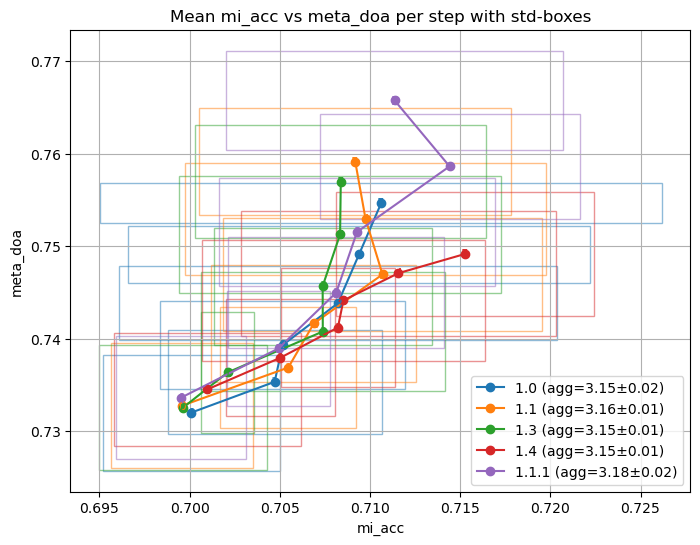

In [8]:
from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.pyplot as plt

results = {'0.1': [({0: {'mi_acc': 0.7024617195129395}, 1: {'mi_acc': 0.7123087048530579}, 2: {'mi_acc': 0.7186959385871887}, 3: {'mi_acc': 0.7181636691093445}, 4: {'mi_acc': 0.7091150879859924}, 5: {'mi_acc': 0.7079174518585205}}, {0: {'meta_doa': 0.7304157088464726}, 1: {'meta_doa': 0.7362093525885123}, 2: {'meta_doa': 0.7419801177870387}, 3: {'meta_doa': 0.7479364832315564}, 4: {'meta_doa': 0.754558156736822}, 5: {'meta_doa': 0.7609072177387415}})
,({0: {'mi_acc': 0.696319043636322}, 1: {'mi_acc': 0.7015203833580017}, 2: {'mi_acc': 0.7005868554115295}, 3: {'mi_acc': 0.6995198726654053}, 4: {'mi_acc': 0.6977860927581787}, 5: {'mi_acc': 0.6889837384223938}}, {0: {'meta_doa': 0.7420893323347375}, 1: {'meta_doa': 0.7474397481409357}, 2: {'meta_doa': 0.7531876039033885}, 3: {'meta_doa': 0.7593381197734652}, 4: {'meta_doa': 0.7654967810706266}, 5: {'meta_doa': 0.7714437858071579}})
,({0: {'mi_acc': 0.7041732668876648}, 1: {'mi_acc': 0.702984631061554}, 2: {'mi_acc': 0.7060221433639526}, 3: {'mi_acc': 0.708135187625885}, 4: {'mi_acc': 0.7119650840759277}, 5: {'mi_acc': 0.7070786952972412}}, {0: {'meta_doa': 0.7296420212377456}, 1: {'meta_doa': 0.735168283602593}, 2: {'meta_doa': 0.7415512178428751}, 3: {'meta_doa': 0.7484768508498663}, 4: {'meta_doa': 0.7552495666779987}, 5: {'meta_doa': 0.7624542636622513}})
],
'0.2' : [
    ({0: {'mi_acc': 0.7035262584686279}, 1: {'mi_acc': 0.7136393785476685}, 2: {'mi_acc': 0.7168329954147339}, 3: {'mi_acc': 0.713506281375885}, 4: {'mi_acc': 0.7100465297698975}, 5: {'mi_acc': 0.708050549030304}}, {0: {'meta_doa': 0.7302079015861811}, 1: {'meta_doa': 0.7357447498863741}, 2: {'meta_doa': 0.741341207668524}, 3: {'meta_doa': 0.7471324260662777}, 4: {'meta_doa': 0.753544268965468}, 5: {'meta_doa': 0.7596752634874964}})
,({0: {'mi_acc': 0.6944518685340881}, 1: {'mi_acc': 0.7023206353187561}, 2: {'mi_acc': 0.6997866034507751}, 3: {'mi_acc': 0.7053881287574768}, 4: {'mi_acc': 0.7043211460113525}, 5: {'mi_acc': 0.6991197466850281}}, {0: {'meta_doa': 0.7417079738698047}, 1: {'meta_doa': 0.7467616925746152}, 2: {'meta_doa': 0.7523662353342592}, 3: {'meta_doa': 0.7584743951457104}, 4: {'meta_doa': 0.7648739490083991}, 5: {'meta_doa': 0.7710205469276834}})
,({0: {'mi_acc': 0.7037770748138428}, 1: {'mi_acc': 0.703380823135376}, 2: {'mi_acc': 0.7028526067733765}, 3: {'mi_acc': 0.7107765078544617}, 4: {'mi_acc': 0.7105123996734619}, 5: {'mi_acc': 0.7019281387329102}}, {0: {'meta_doa': 0.7297894074150179}, 1: {'meta_doa': 0.7354988060297365}, 2: {'meta_doa': 0.741891355661386}, 3: {'meta_doa': 0.7486803070780521}, 4: {'meta_doa': 0.755089099099358}, 5: {'meta_doa': 0.7618397229803056}})

],
'1.0' : [({0: {'mi_acc': 0.7027278542518616}, 1: {'mi_acc': 0.7111110687255859}, 2: {'mi_acc': 0.7127078771591187}, 3: {'mi_acc': 0.7218895554542542}, 4: {'mi_acc': 0.7209580540657043}, 5: {'mi_acc': 0.7233532667160034}}, {0: {'meta_doa': 0.728632032840411}, 1: {'meta_doa': 0.7323657302298043}, 2: {'meta_doa': 0.7366934785670256}, 3: {'meta_doa': 0.7415085743637286}, 4: {'meta_doa': 0.7473583425728835}, 5: {'meta_doa': 0.7533183806596151}})
,({0: {'mi_acc': 0.6944518685340881}, 1: {'mi_acc': 0.6993865370750427}, 2: {'mi_acc': 0.6995198726654053}, 3: {'mi_acc': 0.6987196803092957}, 4: {'mi_acc': 0.695652186870575}, 5: {'mi_acc': 0.6932515501976013}}, {0: {'meta_doa': 0.7392339472373366}, 1: {'meta_doa': 0.7417634575359322}, 2: {'meta_doa': 0.7448334335260457}, 3: {'meta_doa': 0.7484082914481778}, 4: {'meta_doa': 0.7526733783208421}, 5: {'meta_doa': 0.7571144100224763}})
,({0: {'mi_acc': 0.7031167149543762}, 1: {'mi_acc': 0.7036449909210205}, 2: {'mi_acc': 0.7032487988471985}, 3: {'mi_acc': 0.7040411829948425}, 4: {'mi_acc': 0.7115688920021057}, 5: {'mi_acc': 0.715266764163971}}, {0: {'meta_doa': 0.7281229654839478}, 1: {'meta_doa': 0.7318264769943188}, 2: {'meta_doa': 0.7363569613159837}, 3: {'meta_doa': 0.7415253718419961}, 4: {'meta_doa': 0.7472616543795481}, 5: {'meta_doa': 0.7535393904179457}})
],
'1.1':[({0: {'mi_acc': 0.7025948166847229}, 1: {'mi_acc': 0.7097803950309753}, 2: {'mi_acc': 0.7132401466369629}, 3: {'mi_acc': 0.7206919193267822}, 4: {'mi_acc': 0.719228208065033}, 5: {'mi_acc': 0.718030571937561}}, {0: {'meta_doa': 0.729058160038057}, 1: {'meta_doa': 0.7332454818953562}, 2: {'meta_doa': 0.7379187193903707}, 3: {'meta_doa': 0.7429434599864662}, 4: {'meta_doa': 0.7490626336284499}, 5: {'meta_doa': 0.7551611431191707}})
,({0: {'mi_acc': 0.6951187252998352}, 1: {'mi_acc': 0.7028540968894958}, 2: {'mi_acc': 0.7023206353187561}, 3: {'mi_acc': 0.7037876844406128}, 4: {'mi_acc': 0.6992531418800354}, 5: {'mi_acc': 0.7007201910018921}}, {0: {'meta_doa': 0.7405175833503886}, 1: {'meta_doa': 0.7443747299227343}, 2: {'meta_doa': 0.748878735572517}, 3: {'meta_doa': 0.7540054886425591}, 4: {'meta_doa': 0.7598860006687269}, 5: {'meta_doa': 0.7657883404760895}})
,({0: {'mi_acc': 0.7010036706924438}, 1: {'mi_acc': 0.7037770748138428}, 2: {'mi_acc': 0.7050976753234863}, 3: {'mi_acc': 0.7076069712638855}, 4: {'mi_acc': 0.7107765078544617}, 5: {'mi_acc': 0.7087955474853516}}, {0: {'meta_doa': 0.7286338532081575}, 1: {'meta_doa': 0.7329671320168523}, 2: {'meta_doa': 0.7380837067577208}, 3: {'meta_doa': 0.7438462194440569}, 4: {'meta_doa': 0.7498840825302162}, 5: {'meta_doa': 0.7564725465396442}})
],
'1.2' : [({0: {'mi_acc': 0.7072521448135376}, 1: {'mi_acc': 0.7097803950309753}, 2: {'mi_acc': 0.7132401466369629}, 3: {'mi_acc': 0.7182967066764832}, 4: {'mi_acc': 0.7169660329818726}, 5: {'mi_acc': 0.7205588817596436}}, {0: {'meta_doa': 0.7272705545969163}, 1: {'meta_doa': 0.7290081891496057}, 2: {'meta_doa': 0.7310016256061844}, 3: {'meta_doa': 0.7331538091417871}, 4: {'meta_doa': 0.7356597995520301}, 5: {'meta_doa': 0.7381435805290737}})
,({0: {'mi_acc': 0.6949853301048279}, 1: {'mi_acc': 0.6969858407974243}, 2: {'mi_acc': 0.7004534602165222}, 3: {'mi_acc': 0.7003200650215149}, 4: {'mi_acc': 0.693118155002594}, 5: {'mi_acc': 0.6924512982368469}}, {0: {'meta_doa': 0.7386406408729571}, 1: {'meta_doa': 0.7403802518908068}, 2: {'meta_doa': 0.7424018917288657}, 3: {'meta_doa': 0.7446598873561615}, 4: {'meta_doa': 0.747235997526458}, 5: {'meta_doa': 0.7498431708543586}})
,({0: {'mi_acc': 0.7031167149543762}, 1: {'mi_acc': 0.7087955474853516}, 2: {'mi_acc': 0.7065504193305969}, 3: {'mi_acc': 0.7106444239616394}, 4: {'mi_acc': 0.7090596556663513}, 5: {'mi_acc': 0.7126254439353943}}, {0: {'meta_doa': 0.7266256101017365}, 1: {'meta_doa': 0.7282065850751633}, 2: {'meta_doa': 0.7300321310827229}, 3: {'meta_doa': 0.7321002699743802}, 4: {'meta_doa': 0.7342875259830877}, 5: {'meta_doa': 0.7365531561856646}})
],
'1.3' : [({0: {'mi_acc': 0.70379239320755}, 1: {'mi_acc': 0.7032601237297058}, 2: {'mi_acc': 0.714970052242279}, 3: {'mi_acc': 0.7143046855926514}, 4: {'mi_acc': 0.7177644371986389}, 5: {'mi_acc': 0.7157684564590454}}, {0: {'meta_doa': 0.7287960440936148}, 1: {'meta_doa': 0.7326169464297774}, 2: {'meta_doa': 0.736849082689666}, 3: {'meta_doa': 0.7414030745728881}, 4: {'meta_doa': 0.7469685755413185}, 5: {'meta_doa': 0.7525239659460552}})
,({0: {'mi_acc': 0.6945852041244507}, 1: {'mi_acc': 0.702587366104126}, 2: {'mi_acc': 0.7052547335624695}, 3: {'mi_acc': 0.703254222869873}, 4: {'mi_acc': 0.700053334236145}, 5: {'mi_acc': 0.6997866034507751}}, {0: {'meta_doa': 0.7403053160293557}, 1: {'meta_doa': 0.7439228222086801}, 2: {'meta_doa': 0.7481409348347665}, 3: {'meta_doa': 0.7529323505191376}, 4: {'meta_doa': 0.7584888026279093}, 5: {'meta_doa': 0.7639669629070553}})
,({0: {'mi_acc': 0.7004753947257996}, 1: {'mi_acc': 0.7004753947257996}, 2: {'mi_acc': 0.7019281387329102}, 3: {'mi_acc': 0.7045694589614868}, 4: {'mi_acc': 0.7072107195854187}, 5: {'mi_acc': 0.7095879316329956}}, {0: {'meta_doa': 0.728417297364407}, 1: {'meta_doa': 0.7324678692913393}, 2: {'meta_doa': 0.7372841905755022}, 3: {'meta_doa': 0.7426650686652378}, 4: {'meta_doa': 0.74832263031932}, 5: {'meta_doa': 0.7543933126635449}})
],
'1.4':[({0: {'mi_acc': 0.70379239320755}, 1: {'mi_acc': 0.7081835865974426}, 2: {'mi_acc': 0.7116433382034302}, 3: {'mi_acc': 0.7174983024597168}, 4: {'mi_acc': 0.7210911512374878}, 5: {'mi_acc': 0.7232202291488647}}, {0: {'meta_doa': 0.7314570519625334}, 1: {'meta_doa': 0.7345345347701221}, 2: {'meta_doa': 0.737542949843727}, 3: {'meta_doa': 0.7400816855082482}, 4: {'meta_doa': 0.742738219716837}, 5: {'meta_doa': 0.7443357430464823}})
,({0: {'mi_acc': 0.6949853301048279}, 1: {'mi_acc': 0.7021872401237488}, 2: {'mi_acc': 0.7076553702354431}, 3: {'mi_acc': 0.7028540968894958}, 4: {'mi_acc': 0.7039210796356201}, 5: {'mi_acc': 0.7093891501426697}}, {0: {'meta_doa': 0.7415572313469527}, 1: {'meta_doa': 0.745207479510527}, 2: {'meta_doa': 0.7485806292985168}, 3: {'meta_doa': 0.7516771927705801}, 4: {'meta_doa': 0.7548371170350672}, 5: {'meta_doa': 0.7568423016551636}})
,({0: {'mi_acc': 0.7041732668876648}, 1: {'mi_acc': 0.7047014832496643}, 2: {'mi_acc': 0.7053618431091309}, 3: {'mi_acc': 0.7052297592163086}, 4: {'mi_acc': 0.7097200155258179}, 5: {'mi_acc': 0.7131537199020386}}, {0: {'meta_doa': 0.7304910244677627}, 1: {'meta_doa': 0.7340068287343049}, 2: {'meta_doa': 0.7374370390621822}, 3: {'meta_doa': 0.7406261551178124}, 4: {'meta_doa': 0.7436278688125357}, 5: {'meta_doa': 0.7462357698525106}})
],
'1.5' : [({0: {'mi_acc': 0.6815523505210876}, 1: {'mi_acc': 0.6834130883216858}, 2: {'mi_acc': 0.6866028904914856}, 3: {'mi_acc': 0.6939128041267395}, 4: {'mi_acc': 0.6947102546691895}, 5: {'mi_acc': 0.695108950138092}}, {0: {'meta_doa': 0.7301686309570075}, 1: {'meta_doa': 0.7353672939495888}, 2: {'meta_doa': 0.7409937285626709}, 3: {'meta_doa': 0.7471584327496268}, 4: {'meta_doa': 0.7537731802339376}, 5: {'meta_doa': 0.7600337765012938}})
,({0: {'mi_acc': 0.6890767216682434}, 1: {'mi_acc': 0.6920289397239685}, 2: {'mi_acc': 0.6939076781272888}, 3: {'mi_acc': 0.6956521272659302}, 4: {'mi_acc': 0.6972624659538269}, 5: {'mi_acc': 0.6991411447525024}}, {0: {'meta_doa': 0.7414444836192926}, 1: {'meta_doa': 0.7468860999238613}, 2: {'meta_doa': 0.7525701765619079}, 3: {'meta_doa': 0.7582523291346002}, 4: {'meta_doa': 0.7641344500057432}, 5: {'meta_doa': 0.7694235413016305}})
,({0: {'mi_acc': 0.6906638145446777}, 1: {'mi_acc': 0.6873247027397156}, 2: {'mi_acc': 0.6851876378059387}, 3: {'mi_acc': 0.6847869157791138}, 4: {'mi_acc': 0.6870575547218323}, 5: {'mi_acc': 0.6826499104499817}}, {0: {'meta_doa': 0.730435496035188}, 1: {'meta_doa': 0.7358528490701131}, 2: {'meta_doa': 0.7416880460387134}, 3: {'meta_doa': 0.7479545436840593}, 4: {'meta_doa': 0.7549801120191657}, 5: {'meta_doa': 0.7616966140642893}})
],
'2.1' : [({0: {'mi_acc': 0.7011310458183289}, 1: {'mi_acc': 0.7035262584686279}, 2: {'mi_acc': 0.7029939889907837}, 3: {'mi_acc': 0.7055222392082214}, 4: {'mi_acc': 0.7064537405967712}, 5: {'mi_acc': 0.7092481255531311}}, {0: {'meta_doa': 0.7275916121736259}, 1: {'meta_doa': 0.7298565133234678}, 2: {'meta_doa': 0.7324141053327358}, 3: {'meta_doa': 0.735239592469953}, 4: {'meta_doa': 0.7388227669355306}, 5: {'meta_doa': 0.7425176190971344}})
,({0: {'mi_acc': 0.6924512982368469}, 1: {'mi_acc': 0.6993865370750427}, 2: {'mi_acc': 0.7004534602165222}, 3: {'mi_acc': 0.7004534602165222}, 4: {'mi_acc': 0.7015203833580017}, 5: {'mi_acc': 0.7073886394500732}}, {0: {'meta_doa': 0.7390097040533763}, 1: {'meta_doa': 0.741160494834434}, 2: {'meta_doa': 0.7437489819747992}, 3: {'meta_doa': 0.7468453488338467}, 4: {'meta_doa': 0.7505788067749948}, 5: {'meta_doa': 0.7544117343053149}})
,({0: {'mi_acc': 0.7052297592163086}, 1: {'mi_acc': 0.7004753947257996}, 2: {'mi_acc': 0.7025884389877319}, 3: {'mi_acc': 0.7057580351829529}, 4: {'mi_acc': 0.7047014832496643}, 5: {'mi_acc': 0.708135187625885}}, {0: {'meta_doa': 0.727185404423964}, 1: {'meta_doa': 0.7294162252461429}, 2: {'meta_doa': 0.7322511756166521}, 3: {'meta_doa': 0.7355335228847191}, 4: {'meta_doa': 0.7393309457233095}, 5: {'meta_doa': 0.743344040776713}})
],
'2.2' : [({0: {'mi_acc': 0.7000665068626404}, 1: {'mi_acc': 0.7011310458183289}, 2: {'mi_acc': 0.7016633152961731}, 3: {'mi_acc': 0.7065867781639099}, 4: {'mi_acc': 0.7116433382034302}, 5: {'mi_acc': 0.7120425701141357}}, {0: {'meta_doa': 0.7277531819924046}, 1: {'meta_doa': 0.7302331613850152}, 2: {'meta_doa': 0.7330300663472891}, 3: {'meta_doa': 0.7360894925698067}, 4: {'meta_doa': 0.7399657855650075}, 5: {'meta_doa': 0.7438967239896874}}),
         ({0: {'mi_acc': 0.6913843750953674}, 1: {'mi_acc': 0.6977860927581787}, 2: {'mi_acc': 0.700986921787262}, 3: {'mi_acc': 0.7020539045333862}, 4: {'mi_acc': 0.7015203833580017}, 5: {'mi_acc': 0.7073886394500732}}, {0: {'meta_doa': 0.7388937971074622}, 1: {'meta_doa': 0.7409149920876266}, 2: {'meta_doa': 0.7433720892151023}, 3: {'meta_doa': 0.7462735632581019}, 4: {'meta_doa': 0.7498381327983608}, 5: {'meta_doa': 0.7534619262567137}}),
         ({0: {'mi_acc': 0.7052297592163086}, 1: {'mi_acc': 0.7020602226257324}, 2: {'mi_acc': 0.7036449909210205}, 3: {'mi_acc': 0.7052297592163086}, 4: {'mi_acc': 0.7052297592163086}, 5: {'mi_acc': 0.7041732668876648}}, {0: {'meta_doa': 0.7271483391205933}, 1: {'meta_doa': 0.7293522814970297}, 2: {'meta_doa': 0.7321246074089562}, 3: {'meta_doa': 0.7353384133659708}, 4: {'meta_doa': 0.7390672214928493}, 5: {'meta_doa': 0.74306389496818}})
         ],
'2.3' : [({0: {'mi_acc': 0.7016633152961731}, 1: {'mi_acc': 0.7027278542518616}, 2: {'mi_acc': 0.7029939889907837}, 3: {'mi_acc': 0.7047238349914551}, 4: {'mi_acc': 0.7061876058578491}, 5: {'mi_acc': 0.7112441658973694}}, {0: {'meta_doa': 0.7275147520064043}, 1: {'meta_doa': 0.7297384929402447}, 2: {'meta_doa': 0.7322759801520097}, 3: {'meta_doa': 0.7350763050558301}, 4: {'meta_doa': 0.7385977456230277}, 5: {'meta_doa': 0.7422155362009064}})
,({0: {'mi_acc': 0.6919178366661072}, 1: {'mi_acc': 0.6961856484413147}, 2: {'mi_acc': 0.700986921787262}, 3: {'mi_acc': 0.700986921787262}, 4: {'mi_acc': 0.6993865370750427}, 5: {'mi_acc': 0.7044545412063599}}, {0: {'meta_doa': 0.7385914912492242}, 1: {'meta_doa': 0.7403156343717665}, 2: {'meta_doa': 0.7424180869088068}, 3: {'meta_doa': 0.7449573562902281}, 4: {'meta_doa': 0.7481167918505972}, 5: {'meta_doa': 0.7513931845526826}})
,({0: {'mi_acc': 0.7047014832496643}, 1: {'mi_acc': 0.7020602226257324}, 2: {'mi_acc': 0.7020602226257324}, 3: {'mi_acc': 0.7057580351829529}, 4: {'mi_acc': 0.7062863111495972}, 5: {'mi_acc': 0.707342803478241}}, {0: {'meta_doa': 0.7269618509210332}, 1: {'meta_doa': 0.7289193234213083}, 2: {'meta_doa': 0.7313810273890797}, 3: {'meta_doa': 0.7342958415104794}, 4: {'meta_doa': 0.7377417484865507}, 5: {'meta_doa': 0.7414323340649451}})
],
'2.4' : [({0: {'mi_acc': 0.7000665068626404}, 1: {'mi_acc': 0.7040585279464722}, 2: {'mi_acc': 0.70379239320755}, 3: {'mi_acc': 0.7093812227249146}, 4: {'mi_acc': 0.7133732438087463}, 5: {'mi_acc': 0.7131071090698242}}, {0: {'meta_doa': 0.7270217359490531}, 1: {'meta_doa': 0.7285966334456258}, 2: {'meta_doa': 0.730495158377432}, 3: {'meta_doa': 0.732670562542978}, 4: {'meta_doa': 0.7354337036431029}, 5: {'meta_doa': 0.7383139162170106}})
        ,({0: {'mi_acc': 0.6919178366661072}, 1: {'mi_acc': 0.695652186870575}, 2: {'mi_acc': 0.700986921787262}, 3: {'mi_acc': 0.6988530158996582}, 4: {'mi_acc': 0.6992531418800354}, 5: {'mi_acc': 0.6987196803092957}}, {0: {'meta_doa': 0.7383566632730941}, 1: {'meta_doa': 0.7398126670937226}, 2: {'meta_doa': 0.741642856389918}, 3: {'meta_doa': 0.7438670646824801}, 4: {'meta_doa': 0.7466394416903568}, 5: {'meta_doa': 0.7495594893565216}})
        ,({0: {'mi_acc': 0.7047014832496643}, 1: {'mi_acc': 0.7015319466590881}, 2: {'mi_acc': 0.7047014832496643}, 3: {'mi_acc': 0.7062863111495972}, 4: {'mi_acc': 0.7052297592163086}, 5: {'mi_acc': 0.7031167149543762}}, {0: {'meta_doa': 0.7271015349305587}, 1: {'meta_doa': 0.7292378439677482}, 2: {'meta_doa': 0.7319093949299067}, 3: {'meta_doa': 0.7350420765193718}, 4: {'meta_doa': 0.7386641453856925}, 5: {'meta_doa': 0.7425680527831244}})
        ]
,'1.6' : [({0: {'mi_acc': 0.70379239320755}, 1: {'mi_acc': 0.7081835865974426}, 2: {'mi_acc': 0.7116433382034302}, 3: {'mi_acc': 0.7174983024597168}, 4: {'mi_acc': 0.7210911512374878}, 5: {'mi_acc': 0.7232202291488647}}, {0: {'meta_doa': 0.7314570519625334}, 1: {'meta_doa': 0.7345345347701221}, 2: {'meta_doa': 0.737542949843727}, 3: {'meta_doa': 0.7400816855082482}, 4: {'meta_doa': 0.742738219716837}, 5: {'meta_doa': 0.7443357430464823}})
,({0: {'mi_acc': 0.6949853301048279}, 1: {'mi_acc': 0.7021872401237488}, 2: {'mi_acc': 0.7076553702354431}, 3: {'mi_acc': 0.7028540968894958}, 4: {'mi_acc': 0.7039210796356201}, 5: {'mi_acc': 0.7093891501426697}}, {0: {'meta_doa': 0.7415572313469527}, 1: {'meta_doa': 0.745207479510527}, 2: {'meta_doa': 0.7485806292985168}, 3: {'meta_doa': 0.7516771927705801}, 4: {'meta_doa': 0.7548371170350672}, 5: {'meta_doa': 0.7568423016551636}})
,({0: {'mi_acc': 0.7041732668876648}, 1: {'mi_acc': 0.7047014832496643}, 2: {'mi_acc': 0.7053618431091309}, 3: {'mi_acc': 0.7052297592163086}, 4: {'mi_acc': 0.7097200155258179}, 5: {'mi_acc': 0.7131537199020386}}, {0: {'meta_doa': 0.7304910244677627}, 1: {'meta_doa': 0.7340068287343049}, 2: {'meta_doa': 0.7374370390621822}, 3: {'meta_doa': 0.7406261551178124}, 4: {'meta_doa': 0.7436278688125357}, 5: {'meta_doa': 0.7462357698525106}})
],
'1.1.1' : [({0: {'mi_acc': 0.7011310458183289}, 1: {'mi_acc': 0.7077844142913818}, 2: {'mi_acc': 0.714970052242279}, 3: {'mi_acc': 0.718030571937561}, 4: {'mi_acc': 0.7224218249320984}, 5: {'mi_acc': 0.7221556901931763}}, {0: {'meta_doa': 0.7299579118836869}, 1: {'meta_doa': 0.7355792359374441}, 2: {'meta_doa': 0.7415831242475388}, 3: {'meta_doa': 0.7478661281519497}, 4: {'meta_doa': 0.7551502085962118}, 5: {'meta_doa': 0.7621934288153109}})
,({0: {'mi_acc': 0.6953854560852051}, 1: {'mi_acc': 0.7020539045333862}, 2: {'mi_acc': 0.7037876844406128}, 3: {'mi_acc': 0.7040544152259827}, 4: {'mi_acc': 0.7084556221961975}, 5: {'mi_acc': 0.7059215903282166}}, {0: {'meta_doa': 0.7413119467260594}, 1: {'meta_doa': 0.746144398897223}, 2: {'meta_doa': 0.7518580058678133}, 3: {'meta_doa': 0.7581955106344347}, 4: {'meta_doa': 0.7651403584579446}, 5: {'meta_doa': 0.7719467288716008}})
,({0: {'mi_acc': 0.7020602226257324}, 1: {'mi_acc': 0.7049656510353088}, 2: {'mi_acc': 0.7056259512901306}, 3: {'mi_acc': 0.7057580351829529}, 4: {'mi_acc': 0.7123612761497498}, 5: {'mi_acc': 0.7060221433639526}}, {0: {'meta_doa': 0.7295479838030824}, 1: {'meta_doa': 0.7350816041482142}, 2: {'meta_doa': 0.7414585682502811}, 3: {'meta_doa': 0.7485013594424352}, 4: {'meta_doa': 0.7555595976776479}, 5: {'meta_doa': 0.7630804535660705}})
]
 }

aggregated_results = {'0.1' : [3.1816243838502363,3.165585824054796,3.161007273028137],
                      '0.2' : [3.1762183571250606,3.1788138671759896,3.1557863639472536],
                      '1.0' : [3.176887270316704,3.1245647826094185,3.1375178398117605],
                      '1.1' : [3.175398119063823,3.162503259042788,3.1425767083098],
                      '1.2' : [3.139120054380048,3.1080499097540093,3.1086598603491424],
                      '1.3' : [3.1593345104331734,3.159605147372785,3.128623935230042]
                      ,'1.4' : [3.1647547149447925,3.1649445529664186,3.134067903942248]
                      ,'1.5' : [3.0793992576342166,3.1482109259054356,3.069327087092879]
                      ,'1.6' : [3.1647547149447925,3.1649445529664186,3.134067903942248]
                      ,'2.1' : [3.1057942240187515,3.1343864802591086,3.1047464961615656]
                      ,'2.2' : [3.131895326335944,3.1121940347138226,3.103052147250946]
                      ,'2.3' : [3.1055744268028755,3.12161763371129,3.1012487982343324]
                      ,'2.4' : [3.1069335447155124,3.1110920716558086,3.1019409146659305]
                      ,'1.1.1' : [3.1955874550889427,3.189292287824011,3.158830254487752]
                      }

select = [#'0.1' ,
          #'0.2' ,
          '1.0' ,
          '1.1' ,
          #'1.2' ,
          '1.3' ,
          '1.4',
          #'1.5' ,
          #'1.6',
          #'2.1' ,
          #'2.2' ,
          #'2.3',
          #'2.4'
          '1.1.1'
          ]

from matplotlib.patches import Rectangle

plt.figure(figsize=(8, 6))
ax = plt.gca()
colors = plt.cm.tab10.colors

for idx, label in enumerate(select):

    runs = results[label]
    # extract acc and doa values for each run and each step
    acc_vals = [[run[0][i]['mi_acc'] for i in range(len(run[0]))] for run in runs]
    doa_vals = [[run[1][i]['meta_doa'] for i in range(len(run[1]))] for run in runs]
    
    acc_array = torch.tensor(acc_vals)
    doa_array = torch.tensor(doa_vals)
    
    mean_acc = acc_array.mean(dim=0)
    std_acc  = acc_array.std(dim=0)
    mean_doa = doa_array.mean(dim=0)
    std_doa  = doa_array.std(dim=0)
    
    # compute aggregated mean & std
    agg_vals   = aggregated_results[label]
    mean_agg   = np.mean(agg_vals)
    std_agg    = np.std(agg_vals)
    legend_txt = f"{label} (agg={round(mean_agg,2):.2f}±{round(std_agg,2):.2f})"
    
    color = colors[idx % len(colors)]
    # plot the mean curve with updated legend
    ax.plot(mean_acc, mean_doa, marker='o', color=color, label=legend_txt)
    
    # draw uncertainty boxes around each point
    for x, y, sx, sy in zip(mean_acc, mean_doa, std_acc, std_doa):
        rect = Rectangle((x - sx, y - sy), 2*sx, 2*sy,
                         edgecolor=color, facecolor='none', alpha=0.5)
        ax.add_patch(rect)
    
    # annotate each point with its step index
    for step, (x, y) in enumerate(zip(mean_acc, mean_doa)):
        ax.text(x, y, str(step), color=color, fontsize=9, ha='center', va='center')

ax.set_xlabel('mi_acc')
ax.set_ylabel('meta_doa')
ax.set_title('Mean mi_acc vs meta_doa per step with std‐boxes')
ax.grid(True)
ax.legend()
plt.show()


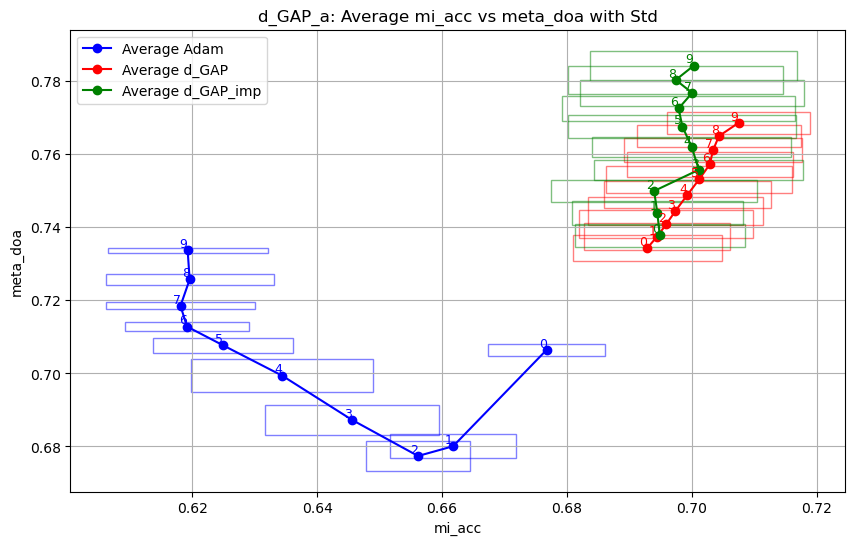

In [1]:
import matplotlib.pyplot as plt
import torch
from matplotlib.patches import Ellipse
import numpy as np
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
from matplotlib.patches import Rectangle

d_GAP_a = [({0: {'mi_acc': 0.685695230960846}, 1: {'mi_acc': 0.7016633152961731}, 2: {'mi_acc': 0.6994011998176575}, 3: {'mi_acc': 0.7025948166847229}, 4: {'mi_acc': 0.704457700252533}, 5: {'mi_acc': 0.7021955847740173}, 6: {'mi_acc': 0.7036593556404114}, 7: {'mi_acc': 0.7023286819458008}, 8: {'mi_acc': 0.7072521448135376}, 9: {'mi_acc': 0.7031270861625671}}, {0: {'meta_doa': 0.7425898990548128}, 1: {'meta_doa': 0.749311884665743}, 2: {'meta_doa': 0.7553632393188774}, 3: {'meta_doa': 0.7610620790878874}, 4: {'meta_doa': 0.7676201808622714}, 5: {'meta_doa': 0.7732922975842338}, 6: {'meta_doa': 0.7778605529395959}, 7: {'meta_doa': 0.7814299670893767}, 8: {'meta_doa': 0.783476366305087}, 9: {'meta_doa': 0.7861964471779208}}),
            ({0: {'mi_acc': 0.6924816966056824}, 1: {'mi_acc': 0.688090443611145}, 2: {'mi_acc': 0.6890219449996948}, 3: {'mi_acc': 0.6924816966056824}, 4: {'mi_acc': 0.6988689303398132}, 5: {'mi_acc': 0.699268102645874}, 6: {'mi_acc': 0.7045907974243164}, 7: {'mi_acc': 0.7085828185081482}, 8: {'mi_acc': 0.7137724161148071}, 9: {'mi_acc': 0.7129740118980408}}, {0: {'meta_doa': 0.7375820395563277}, 1: {'meta_doa': 0.743702927822403}, 2: {'meta_doa': 0.7496316102820149}, 3: {'meta_doa': 0.7556105729304318}, 4: {'meta_doa': 0.7622220184721762}, 5: {'meta_doa': 0.7680864617307456}, 6: {'meta_doa': 0.7732972247203452}, 7: {'meta_doa': 0.7775575861063695}, 8: {'meta_doa': 0.7806692145019951}, 9: {'meta_doa': 0.7845093807608309}}),
            ({0: {'mi_acc': 0.6778442859649658}, 1: {'mi_acc': 0.6746506690979004}, 2: {'mi_acc': 0.6694610714912415}, 3: {'mi_acc': 0.6783765554428101}, 4: {'mi_acc': 0.6773120164871216}, 5: {'mi_acc': 0.6710578799247742}, 6: {'mi_acc': 0.6709247827529907}, 7: {'mi_acc': 0.672920823097229}, 8: {'mi_acc': 0.6761144399642944}, 9: {'mi_acc': 0.6803725957870483}}, {0: {'meta_doa': 0.734784130278634}, 1: {'meta_doa': 0.7414256217018026}, 2: {'meta_doa': 0.7484298542067631}, 3: {'meta_doa': 0.7549252857544732}, 4: {'meta_doa': 0.7617443577838665}, 5: {'meta_doa': 0.76795092250738}, 6: {'meta_doa': 0.773430443606006}, 7: {'meta_doa': 0.7784805595182239}, 8: {'meta_doa': 0.7834176500788027}, 9: {'meta_doa': 0.7885397658166611}}),
            ({0: {'mi_acc': 0.6975382566452026}, 1: {'mi_acc': 0.6994011998176575}, 2: {'mi_acc': 0.693812370300293}, 3: {'mi_acc': 0.6986027956008911}, 4: {'mi_acc': 0.696207582950592}, 5: {'mi_acc': 0.6903526186943054}, 6: {'mi_acc': 0.6830338835716248}, 7: {'mi_acc': 0.6811710000038147}, 8: {'mi_acc': 0.6751829385757446}, 9: {'mi_acc': 0.6757152080535889}}, {0: {'meta_doa': 0.7351373608841452}, 1: {'meta_doa': 0.7414663209396681}, 2: {'meta_doa': 0.7477462158690142}, 3: {'meta_doa': 0.7543154742438181}, 4: {'meta_doa': 0.7606192501042921}, 5: {'meta_doa': 0.7663572060941142}, 6: {'meta_doa': 0.772058872833216}, 7: {'meta_doa': 0.7775053494436348}, 8: {'meta_doa': 0.7829197281055174}, 9: {'meta_doa': 0.7882289762326431}}),
            ({0: {'mi_acc': 0.7145708203315735}, 1: {'mi_acc': 0.7109780311584473}, 2: {'mi_acc': 0.7152361869812012}, 3: {'mi_acc': 0.7186959385871887}, 4: {'mi_acc': 0.7131071090698242}, 5: {'mi_acc': 0.7067198753356934}, 6: {'mi_acc': 0.7095142602920532}, 7: {'mi_acc': 0.7168329954147339}, 8: {'mi_acc': 0.7071190476417542}, 9: {'mi_acc': 0.7040585279464722}}, {0: {'meta_doa': 0.7398969855524276}, 1: {'meta_doa': 0.7462963056171483}, 2: {'meta_doa': 0.7521570500168024}, 3: {'meta_doa': 0.7580234798106895}, 4: {'meta_doa': 0.7642125091861154}, 5: {'meta_doa': 0.7700751496641978}, 6: {'meta_doa': 0.7758483714647566}, 7: {'meta_doa': 0.7813191969410814}, 8: {'meta_doa': 0.7863799072203295}, 9: {'meta_doa': 0.7920269574924161}})
            ]

d_Adam = [({0: {'mi_acc': 0.6924816966056824}, 1: {'mi_acc': 0.6771789789199829}, 2: {'mi_acc': 0.670791745185852}, 3: {'mi_acc': 0.6691949367523193}, 4: {'mi_acc': 0.6582834124565125}, 5: {'mi_acc': 0.642980694770813}, 6: {'mi_acc': 0.6351297497749329}, 7: {'mi_acc': 0.6303393244743347}, 8: {'mi_acc': 0.6345974802970886}, 9: {'mi_acc': 0.6364603638648987}}, {0: {'meta_doa': 0.7084562737120852}, 1: {'meta_doa': 0.6850781554614311}, 2: {'meta_doa': 0.682928486959986}, 3: {'meta_doa': 0.693269915487039}, 4: {'meta_doa': 0.7054253448774888}, 5: {'meta_doa': 0.7099752393738058}, 6: {'meta_doa': 0.714113389000296}, 7: {'meta_doa': 0.7173318827510364}, 8: {'meta_doa': 0.7235426267672171}, 9: {'meta_doa': 0.7325243926819851}}),
          ({0: {'mi_acc': 0.6754490733146667}, 1: {'mi_acc': 0.6600132584571838}, 2: {'mi_acc': 0.6540252566337585}, 3: {'mi_acc': 0.6419161558151245}, 4: {'mi_acc': 0.6347305178642273}, 5: {'mi_acc': 0.6254158020019531}, 6: {'mi_acc': 0.6157019138336182}, 7: {'mi_acc': 0.6106453537940979}, 8: {'mi_acc': 0.6081171035766602}, 9: {'mi_acc': 0.6082501411437988}}, {0: {'meta_doa': 0.7039300763107585}, 1: {'meta_doa': 0.6772116043240841}, 2: {'meta_doa': 0.6724957867685301}, 3: {'meta_doa': 0.68258010098621}, 4: {'meta_doa': 0.6958730404034936}, 5: {'meta_doa': 0.7058072795509229}, 6: {'meta_doa': 0.712499647195145}, 7: {'meta_doa': 0.7176315541533602}, 8: {'meta_doa': 0.7267020862522149}, 9: {'meta_doa': 0.7340983508301016}}),
          ({0: {'mi_acc': 0.6751829385757446}, 1: {'mi_acc': 0.6633399724960327}, 2: {'mi_acc': 0.6504324674606323}, 3: {'mi_acc': 0.6320691704750061}, 4: {'mi_acc': 0.6210246086120605}, 5: {'mi_acc': 0.6214237809181213}, 6: {'mi_acc': 0.6198269724845886}, 7: {'mi_acc': 0.6303393244743347}, 8: {'mi_acc': 0.6302062273025513}, 9: {'mi_acc': 0.6274118423461914}}, {0: {'meta_doa': 0.7070339033903139}, 1: {'meta_doa': 0.6798287946090771}, 2: {'meta_doa': 0.6785959878608936}, 3: {'meta_doa': 0.6895077653169002}, 4: {'meta_doa': 0.7030863960827985}, 5: {'meta_doa': 0.7098424786561868}, 6: {'meta_doa': 0.7142438645192785}, 7: {'meta_doa': 0.7194876444982768}, 8: {'meta_doa': 0.7265793916191463}, 9: {'meta_doa': 0.7333845381735589}}),
          ({0: {'mi_acc': 0.6734530925750732}, 1: {'mi_acc': 0.6592148542404175}, 2: {'mi_acc': 0.6530938148498535}, 3: {'mi_acc': 0.6440452337265015}, 4: {'mi_acc': 0.6333998441696167}, 5: {'mi_acc': 0.6226214170455933}, 6: {'mi_acc': 0.6170325875282288}, 7: {'mi_acc': 0.6157019138336182}, 8: {'mi_acc': 0.6211576461791992}, 9: {'mi_acc': 0.6178309917449951}}, {0: {'meta_doa': 0.7061865035105463}, 1: {'meta_doa': 0.6773145555926567}, 2: {'meta_doa': 0.6746968769817094}, 3: {'meta_doa': 0.6848663876447532}, 4: {'meta_doa': 0.69641817450702}, 5: {'meta_doa': 0.7054941199124167}, 6: {'meta_doa': 0.7114060365727629}, 7: {'meta_doa': 0.7187693101650978}, 8: {'meta_doa': 0.7269312246838588}, 9: {'meta_doa': 0.7344987323374761}}),
          ({0: {'mi_acc': 0.667198896408081}, 1: {'mi_acc': 0.6491017937660217}, 2: {'mi_acc': 0.6524284482002258}, 3: {'mi_acc': 0.6405854821205139}, 4: {'mi_acc': 0.6243512630462646}, 5: {'mi_acc': 0.6122421622276306}, 6: {'mi_acc': 0.6079840064048767}, 7: {'mi_acc': 0.6034597158432007}, 8: {'mi_acc': 0.6037258505821228}, 9: {'mi_acc': 0.6062541604042053}}, {0: {'meta_doa': 0.706544584203283}, 1: {'meta_doa': 0.6807789377223952}, 2: {'meta_doa': 0.6781352255768651}, 3: {'meta_doa': 0.6860748886578804}, 4: {'meta_doa': 0.6961086188094784}, 5: {'meta_doa': 0.7070815545241518}, 6: {'meta_doa': 0.7116876628710169}, 7: {'meta_doa': 0.7190714002027461}, 8: {'meta_doa': 0.7246432490552572}, 9: {'meta_doa': 0.7336166892756256}})]

d_GAP = [({0: {'mi_acc': 0.7107118964195251}, 1: {'mi_acc': 0.7121756076812744}, 2: {'mi_acc': 0.7178975343704224}, 3: {'mi_acc': 0.7198935151100159}, 4: {'mi_acc': 0.7209580540657043}, 5: {'mi_acc': 0.721623420715332}, 6: {'mi_acc': 0.7204257845878601}, 7: {'mi_acc': 0.7220225930213928}, 8: {'mi_acc': 0.7226879596710205}, 9: {'mi_acc': 0.7245509028434753}}, {0: {'meta_doa': 0.7369116313994888}, 1: {'meta_doa': 0.7401776139501453}, 2: {'meta_doa': 0.7435959447412918}, 3: {'meta_doa': 0.7471816729632257}, 4: {'meta_doa': 0.7515102817188273}, 5: {'meta_doa': 0.7555688320721008}, 6: {'meta_doa': 0.7594621140320155}, 7: {'meta_doa': 0.7629448505501149}, 8: {'meta_doa': 0.7665633910411122}, 9: {'meta_doa': 0.7698878509688218}})
,({0: {'mi_acc': 0.6952760815620422}, 1: {'mi_acc': 0.6956753134727478}, 2: {'mi_acc': 0.6971390247344971}, 3: {'mi_acc': 0.6986027956008911}, 4: {'mi_acc': 0.6971390247344971}, 5: {'mi_acc': 0.7048569321632385}, 6: {'mi_acc': 0.7079174518585205}, 7: {'mi_acc': 0.7081835865974426}, 8: {'mi_acc': 0.7064537405967712}, 9: {'mi_acc': 0.7065867781639099}}, {0: {'meta_doa': 0.7313380403345429}, 1: {'meta_doa': 0.7343466544283327}, 2: {'meta_doa': 0.7376895358431659}, 3: {'meta_doa': 0.7414367255407358}, 4: {'meta_doa': 0.74594787427979}, 5: {'meta_doa': 0.7501882120145547}, 6: {'meta_doa': 0.7544839076468445}, 7: {'meta_doa': 0.7586661725182249}, 8: {'meta_doa': 0.7631511144921646}, 9: {'meta_doa': 0.7672700025175572}})
,({0: {'mi_acc': 0.6863605976104736}, 1: {'mi_acc': 0.6879574060440063}, 2: {'mi_acc': 0.6911510229110718}, 3: {'mi_acc': 0.6930139660835266}, 4: {'mi_acc': 0.6978043913841248}, 5: {'mi_acc': 0.7011310458183289}, 6: {'mi_acc': 0.7003326416015625}, 7: {'mi_acc': 0.7007318735122681}, 8: {'mi_acc': 0.7011310458183289}, 9: {'mi_acc': 0.7045907974243164}}, {0: {'meta_doa': 0.7387093409723344}, 1: {'meta_doa': 0.7420726452004549}, 2: {'meta_doa': 0.7456232275642273}, 3: {'meta_doa': 0.7492461085971049}, 4: {'meta_doa': 0.7537760084644033}, 5: {'meta_doa': 0.7581066203152549}, 6: {'meta_doa': 0.7621718509197886}, 7: {'meta_doa': 0.7658752311884067}, 8: {'meta_doa': 0.7694580362905937}, 9: {'meta_doa': 0.7726850967029422}})
,({0: {'mi_acc': 0.6935462355613708}, 1: {'mi_acc': 0.6956753134727478}, 2: {'mi_acc': 0.6936792731285095}, 3: {'mi_acc': 0.6935462355613708}, 4: {'mi_acc': 0.6963406205177307}, 5: {'mi_acc': 0.698336660861969}, 6: {'mi_acc': 0.7019294500350952}, 7: {'mi_acc': 0.7036593556404114}, 8: {'mi_acc': 0.7055222392082214}, 9: {'mi_acc': 0.7092481255531311}}, {0: {'meta_doa': 0.734146425245785}, 1: {'meta_doa': 0.7370432311034407}, 2: {'meta_doa': 0.74019802539909}, 3: {'meta_doa': 0.7436612565858485}, 4: {'meta_doa': 0.7478979334993907}, 5: {'meta_doa': 0.7517718469050243}, 6: {'meta_doa': 0.755358966055041}, 7: {'meta_doa': 0.7585318981304909}, 8: {'meta_doa': 0.7616070045863621}, 9: {'meta_doa': 0.7645023820139965}})
,({0: {'mi_acc': 0.6785096526145935}, 1: {'mi_acc': 0.6806387305259705}, 2: {'mi_acc': 0.679574191570282}, 3: {'mi_acc': 0.6817032098770142}, 4: {'mi_acc': 0.6842315196990967}, 5: {'mi_acc': 0.6799733638763428}, 6: {'mi_acc': 0.6838322877883911}, 7: {'mi_acc': 0.6823685765266418}, 8: {'mi_acc': 0.6859613656997681}, 9: {'mi_acc': 0.692614734172821}}, {0: {'meta_doa': 0.7304106790249607}, 1: {'meta_doa': 0.7332284705808003}, 2: {'meta_doa': 0.7366063234902659}, 3: {'meta_doa': 0.7403180417740645}, 4: {'meta_doa': 0.7450376501605802}, 5: {'meta_doa': 0.7498141948627648}, 6: {'meta_doa': 0.7544579406393028}, 7: {'meta_doa': 0.7590424355716754}, 8: {'meta_doa': 0.7638866425116998}, 9: {'meta_doa': 0.76851892010849}})
]
d_GAP_imp = [({0: {'mi_acc': 0.7160345911979675}, 1: {'mi_acc': 0.7112441658973694}, 2: {'mi_acc': 0.7184298038482666}, 3: {'mi_acc': 0.7225548624992371}, 4: {'mi_acc': 0.7174983024597168}, 5: {'mi_acc': 0.717099130153656}, 6: {'mi_acc': 0.7184298038482666}, 7: {'mi_acc': 0.7213572859764099}, 8: {'mi_acc': 0.7140385508537292}, 9: {'mi_acc': 0.7186959385871887}}, {0: {'meta_doa': 0.7397406324951549}, 1: {'meta_doa': 0.74578505307349}, 2: {'meta_doa': 0.7512004352226899}, 3: {'meta_doa': 0.7566045637421255}, 4: {'meta_doa': 0.7624296709929537}, 5: {'meta_doa': 0.7677490248990957}, 6: {'meta_doa': 0.772579951471229}, 7: {'meta_doa': 0.7765247405674733}, 8: {'meta_doa': 0.7797132600945084}, 9: {'meta_doa': 0.7834471389932254}}),
             ({0: {'mi_acc': 0.6870259046554565}, 1: {'mi_acc': 0.6998003721237183}, 2: {'mi_acc': 0.6958083510398865}, 3: {'mi_acc': 0.7085828185081482}, 4: {'mi_acc': 0.7065867781639099}, 5: {'mi_acc': 0.7056553363800049}, 6: {'mi_acc': 0.7049899697303772}, 7: {'mi_acc': 0.706852912902832}, 8: {'mi_acc': 0.7115103006362915}, 9: {'mi_acc': 0.7087158560752869}}, {0: {'meta_doa': 0.7420978925898805}, 1: {'meta_doa': 0.7485025240765185}, 2: {'meta_doa': 0.7542877433578068}, 3: {'meta_doa': 0.7597665460652698}, 4: {'meta_doa': 0.7663837224770829}, 5: {'meta_doa': 0.7723938907610646}, 6: {'meta_doa': 0.7775750418683307}, 7: {'meta_doa': 0.7820883904120808}, 8: {'meta_doa': 0.7851130477593007}, 9: {'meta_doa': 0.7887356847974121}}),
({0: {'mi_acc': 0.6923485994338989}, 1: {'mi_acc': 0.6883565783500671}, 2: {'mi_acc': 0.6892880797386169}, 3: {'mi_acc': 0.694743812084198}, 4: {'mi_acc': 0.6996673345565796}, 5: {'mi_acc': 0.6999334692955017}, 6: {'mi_acc': 0.6990019679069519}, 7: {'mi_acc': 0.6971390247344971}, 8: {'mi_acc': 0.6911510229110718}, 9: {'mi_acc': 0.6935462355613708}}, {0: {'meta_doa': 0.7375713501602505}, 1: {'meta_doa': 0.7436957012457759}, 2: {'meta_doa': 0.7495316847824807}, 3: {'meta_doa': 0.7552203896727276}, 4: {'meta_doa': 0.7611949566450502}, 5: {'meta_doa': 0.7663649189251024}, 6: {'meta_doa': 0.7708974202170193}, 7: {'meta_doa': 0.7748446846115284}, 8: {'meta_doa': 0.7782005132870223}, 9: {'meta_doa': 0.7818644568450299}}),
({0: {'mi_acc': 0.6802394986152649}, 1: {'mi_acc': 0.6746506690979004}, 2: {'mi_acc': 0.6722554564476013}, 3: {'mi_acc': 0.677445113658905}, 4: {'mi_acc': 0.6742514967918396}, 5: {'mi_acc': 0.6681303977966309}, 6: {'mi_acc': 0.6677311658859253}, 7: {'mi_acc': 0.6722554564476013}, 8: {'mi_acc': 0.671457052230835}, 9: {'mi_acc': 0.6753160357475281}}, {0: {'meta_doa': 0.7345687263618308}, 1: {'meta_doa': 0.7410178900203185}, 2: {'meta_doa': 0.7478989087815044}, 3: {'meta_doa': 0.7542544640477005}, 4: {'meta_doa': 0.7610556793002021}, 5: {'meta_doa': 0.7673503490336786}, 6: {'meta_doa': 0.7728332351219653}, 7: {'meta_doa': 0.777883715265199}, 8: {'meta_doa': 0.7828379176048054}, 9: {'meta_doa': 0.7879944608541867}}),
({0: {'mi_acc': 0.6987358331680298}, 1: {'mi_acc': 0.698336660861969}, 2: {'mi_acc': 0.6940785050392151}, 3: {'mi_acc': 0.7023286819458008}, 4: {'mi_acc': 0.7019294500350952}, 5: {'mi_acc': 0.7016633152961731}, 6: {'mi_acc': 0.699268102645874}, 7: {'mi_acc': 0.7027278542518616}, 8: {'mi_acc': 0.6990019679069519}, 9: {'mi_acc': 0.7052561044692993}}, {0: {'meta_doa': 0.7348493590700207}, 1: {'meta_doa': 0.7407728337498414}, 2: {'meta_doa': 0.7466102875744813}, 3: {'meta_doa': 0.7527167335384894}, 4: {'meta_doa': 0.7587013572041754}, 5: {'meta_doa': 0.7638678859713598}, 6: {'meta_doa': 0.7685892569013142}, 7: {'meta_doa': 0.7723946701094785}, 8: {'meta_doa': 0.7756456020341892}, 9: {'meta_doa': 0.7789824673478142}})

]

    # Plot average curve with uncertainty bands
plt.figure(figsize=(10, 6))


colors = ['blue', 'red', 'green', 'orange']
labels = ['Adam', 'd_GAP','d_GAP_imp']

for xp, color, label in zip([d_Adam, d_GAP,d_GAP_imp], colors, labels):
    mi_acc_array = []
    meta_doa_array = []

    for d in xp:
        mi_acc = [d[0][i]['mi_acc'] for i in range(len(d[0]))]
        meta_doa = [d[1][i]['meta_doa'] for i in range(len(d[1]))]
        mi_acc_array.append(mi_acc)
        meta_doa_array.append(meta_doa)

    mi_acc_array = torch.tensor(mi_acc_array)
    meta_doa_array = torch.tensor(meta_doa_array)

    # Compute mean and std across curves for each step
    mean_mi   = mi_acc_array.mean(dim=0)
    std_mi    = mi_acc_array.std(dim=0)
    mean_meta = meta_doa_array.mean(dim=0)
    std_meta  = meta_doa_array.std(dim=0)

    # Plot average curve
    plt.plot(mean_mi, mean_meta, marker='o', color=color, label=f'Average {label}')
    ax = plt.gca()

    # Add uncertainty boxes
    mean_mi_np   = mean_mi.cpu().numpy()
    std_mi_np    = std_mi.cpu().numpy()
    mean_meta_np = mean_meta.cpu().numpy()
    std_meta_np  = std_meta.cpu().numpy()

    for x0, y0, dx, dy in zip(mean_mi_np, mean_meta_np, std_mi_np, std_meta_np):
        rect = Rectangle((x0-dx, y0-dy), 2*dx, 2*dy,
                         edgecolor=color, facecolor='none', alpha=0.5)
        ax.add_patch(rect)

    # Annotate each point
    for idx, (x, y) in enumerate(zip(mean_mi, mean_meta)):
        plt.text(x, y, str(idx), fontsize=9, ha='right', va='bottom', color=color)

plt.xlabel('mi_acc')
plt.ylabel('meta_doa')
plt.title('d_GAP_a: Average mi_acc vs meta_doa with Std')
plt.grid(True)
plt.legend()
plt.show()



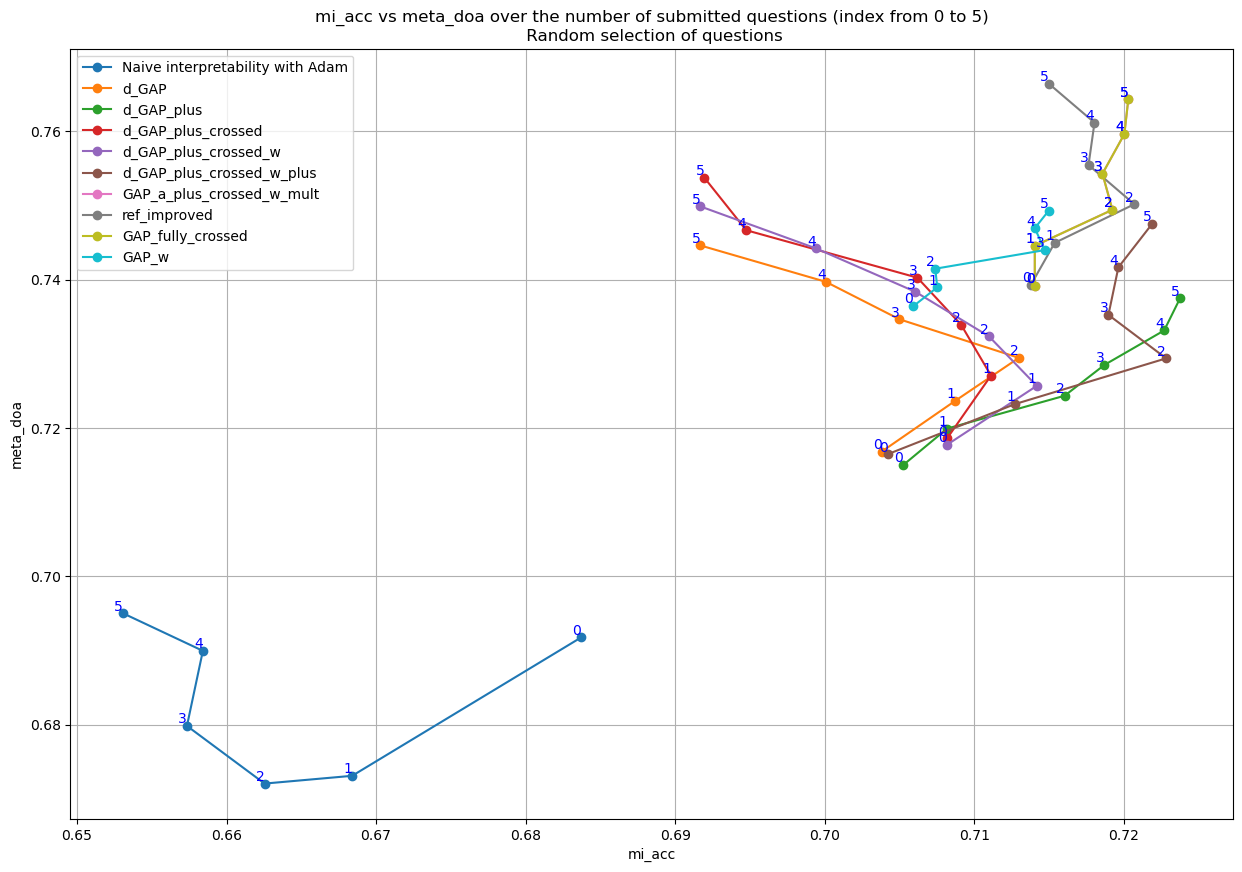